# Home Credit: predicting clients' repayment abilities

Many people struggle to get loans due to insufficient or non-existent credit histories. 

Home Credit Group Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. To make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data -including telco (telecommunications provider) and transactional information -to predict their clients' repayment abilities.

While Home Credit is currently using various statistical methods to make these predictions, they're hoping that our ML project will unlock the full potential of their data. 

By doing so we will ensure that clients capable of repayment are not rejected and that loans are given with trust that will empower their clients to be successful.

# Installs

https://www.kaggle.com/competitions/home-credit-default-risk/overview

In [270]:
!pip install shap
!pip install imblearn
!pip install lightgbm
!pip install xgboost

You should consider upgrading via the '/Users/gabriele/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/gabriele/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/gabriele/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/gabriele/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [271]:
import numpy as np                              
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px                                   
import seaborn as sns                                               
import pandas as pd          
                               
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgbm

import scipy.stats as stats   
from sklearn.model_selection import train_test_split 

import os
import gc

import warnings                                                     
warnings.filterwarnings("ignore")

In [272]:
from sklearn.decomposition import PCA
def pca_results(good_data, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    components = pd.DataFrame(np.round(pca.components_, 4), columns = good_data.keys())
    components.index = dimensions

    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    fig, ax = plt.subplots(figsize = (14,8))

    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)


    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    return pd.concat([variance_ratios, components], axis = 1)



def pca_test(data, n_c):
    pca = PCA(n_components=n_c)
    pca.fit(data)
    
    return pca_results(data, pca)

def pca_reduce_data(data, n_c):    
    pca = PCA(n_components=n_c)
    pca.fit(data)
    reduced_data = pca.transform(data)
    
    return reduced_data

In [273]:
from sklearn.metrics import accuracy_score,classification_report, roc_auc_score, auc
from matplotlib import pyplot

'''Shows basic evaluation metrics'''

def eval(pred):
  print("The accuracy in general is : ", accuracy_score(y_validation_set,pred))
  print("\n")
  print("The classification report is as follows:\n", classification_report(y_validation_set, pred))
  print("ROC AUC score is: ",roc_auc_score(y_validation_set,pred))

In [274]:
def plot_importance(df):
    """
    Builds the dataset to plot the feature importance.
    
    """
    # Sort features according to importance
    df = df.sort_values(['Importance'],ascending=False).reset_index()
    
    # drop the old index to avoid confusion
    df = df.drop(['index'],axis=1)
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 9))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:30]))), 
            df['Importance'].head(30), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:30]))))
    ax.set_yticklabels(df['Feature'].head(30))
    
    plt.xlabel("Normalized feature importance")
    plt.ylabel("Features")
    
    plt.show()
    return df

In [275]:
def plot_kde(column_name):
  str_only = app_train[app_train['TARGET'] == 1]
  no_str_only = app_train[app_train['TARGET'] == 0]
  
  fig = plt.figure(figsize=(10,8))
  ax = fig.add_subplot()


  positive = pd.DataFrame(str_only[column_name])
  negative = pd.DataFrame(no_str_only[column_name])
  sns.kdeplot(positive[column_name], ax=ax,color="#0f4c81", shade=True, ec='black',label="postive")
  sns.kdeplot(negative[column_name], ax=ax, color="#9bb7d4", shade=True, ec='black',label="negative")



  ax.yaxis.set_major_locator(mtick.MultipleLocator(2))
  ax.set_ylabel('')    
  ax.set_xlabel('')
  ax.legend()
  plt.show()

In [276]:
def plot_bar(dataframe, column_name):
  df1 = pd.DataFrame(dataframe, columns=[column_name, 'TARGET'])

  df_2 = df1.groupby([column_name, 'TARGET']).size().reset_index()
  df_2['percentage'] = dataframe.groupby([column_name, 'TARGET']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
  df_2.columns = [column_name, 'TARGET', 'Counts', 'Percentage']

  fig = px.bar(df_2, 
              x= column_name, 
              y=['Counts'], 
              color='TARGET', 
              color_continuous_scale=px.colors.diverging.Portland,  
              text=df_2['Percentage'].apply(lambda x: '{0:1.2f}%'.format(x)))
  fig.update_coloraxes(showscale=False)
  

  fig.update_layout(
    autosize=False,
    legend_title_text='Legend Heading',
    showlegend=True,
    width=800,
    height=500)

  fig.show()

# Data import

In [277]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [278]:
app_train = import_data('application_train.csv')
app_test = import_data('application_test.csv')
bureau = import_data('bureau.csv')
bureau_balance = import_data('bureau_balance.csv')
cash = import_data('POS_CASH_balance.csv')
credit = import_data('credit_card_balance.csv')
previous_app = import_data('previous_application.csv')
installments = import_data('installments_payments.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 59.54 MB
Decreased by 79.2%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 9.40 MB
Decreased by 79.1%
Memory usage of dataframe is 222.62 MB
Memory usage after optimization is: 78.57 MB
Decreased by 64.7%
Memory usage of dataframe is 624.85 MB
Memory usage after optimization is: 156.21 MB
Decreased by 75.0%
Memory usage of dataframe is 610.43 MB
Memory usage after optimization is: 171.69 MB
Decreased by 71.9%
Memory usage of dataframe is 673.88 MB
Memory usage after optimization is: 263.69 MB
Decreased by 60.9%
Memory usage of dataframe is 471.48 MB
Memory usage after optimization is: 130.62 MB
Decreased by 72.3%
Memory usage of dataframe is 830.41 MB
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%


In [279]:
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of POS_CASH_balance data', cash.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_app.shape)
print('Size of installments_payments data', installments.shape)
print('Size of credit_card_balance data', credit.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (10001358, 8)
Size of bureau_balance data (27299925, 3)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)
Size of bureau data (1716428, 17)


In [280]:
app_train = app_train.sort_values(by=['SK_ID_CURR']).tail(170000).reset_index(drop=True)

In [281]:
def find_related(df):
  mask = df['SK_ID_CURR'].isin(app_train['SK_ID_CURR'])
  df = pd.DataFrame(df[mask])
  return df

In [282]:
bureau = find_related(bureau)
previous_app = find_related(previous_app)
installments = find_related(installments)
credit = find_related(credit)
cash = find_related(cash)

In [283]:
mask = bureau_balance['SK_ID_BUREAU'].isin(bureau['SK_ID_BUREAU'])
bureau_balance = pd.DataFrame(bureau_balance[mask])

In [284]:
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of POS_CASH_balance data', cash.shape)
print('Size of bureau_balance data', bureau_balance.shape)
print('Size of previous_application data', previous_app.shape)
print('Size of installments_payments data', installments.shape)
print('Size of credit_card_balance data', credit.shape)
print('Size of bureau data', bureau.shape)

Size of application_train data (170000, 122)
Size of application_test data (48744, 121)
Size of POS_CASH_balance data (4735191, 8)
Size of bureau_balance data (8097173, 3)
Size of previous_application data (783740, 37)
Size of installments_payments data (6425606, 8)
Size of credit_card_balance data (1785645, 23)
Size of bureau data (810339, 17)


# EDA

**app_train**

In [285]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,259486,0,Cash loans,M,Y,Y,1,225000.0,835380.0,40189.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,259487,0,Cash loans,F,N,Y,0,90000.0,511249.5,24723.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,4.0
2,259488,0,Cash loans,F,N,Y,0,225000.0,521280.0,27423.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,259489,0,Cash loans,M,N,N,2,112500.0,803259.0,21316.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,259490,0,Cash loans,F,N,Y,0,90000.0,225000.0,11619.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,6.0


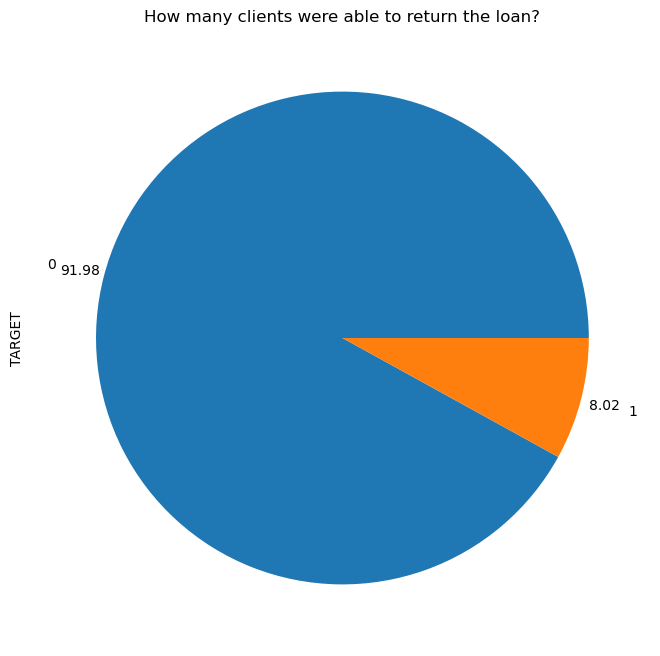

In [286]:
fig = plt.figure(figsize =(8, 8))
app_train.TARGET.value_counts(normalize=True).plot.pie(autopct='%.2f', 
                                                 pctdistance=1.1, 
                                                 labeldistance=1.2)
plt.title('How many clients were able to return the loan?')
plt.show()

In [287]:
plot_bar(app_train, 'CODE_GENDER')

Women are better at returning loans? Well, they are definitely more frequent lenders.

In [288]:
plot_bar(app_train, 'NAME_CONTRACT_TYPE')

In [289]:
plot_bar(app_train, 'NAME_EDUCATION_TYPE')

A lower degree means a lower chance of returning the loan.

In [290]:
plot_bar(app_train, 'NAME_FAMILY_STATUS')

In [291]:
plot_bar(app_train, 'OCCUPATION_TYPE')

HR people - are the most trustworthy people. We should take a closer look when lending to low-skill laborers. 

In [292]:
app_train.select_dtypes('category').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [293]:
app_test.select_dtypes('category').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Annomalies in time series**

In [294]:
(app_train['DAYS_BIRTH']/-365).describe()

count    170000.000000
mean         43.959857
std          11.945256
min          20.517808
25%          34.060274
50%          43.191781
75%          53.939726
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 0, 'Age of the client (Years)')

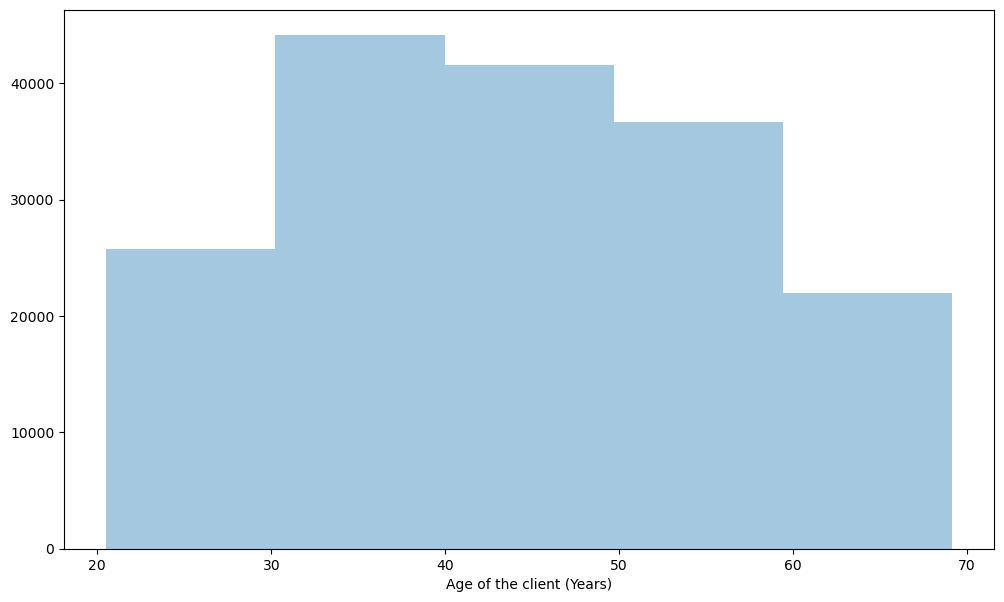

In [295]:
fig, ax = plt.subplots(figsize =(12,7))
sns.distplot(app_train['DAYS_BIRTH']/-365,bins=5,kde=False)
plt.xlabel("Age of the client (Years)")

In [296]:
(app_train['DAYS_EMPLOYED']/365).describe()

count    170000.000000
mean        175.076361
std         387.266957
min         -49.073973
25%          -7.578082
50%          -3.326027
75%          -0.794521
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, 'Time before the loan application the persons started current employment(in years)')

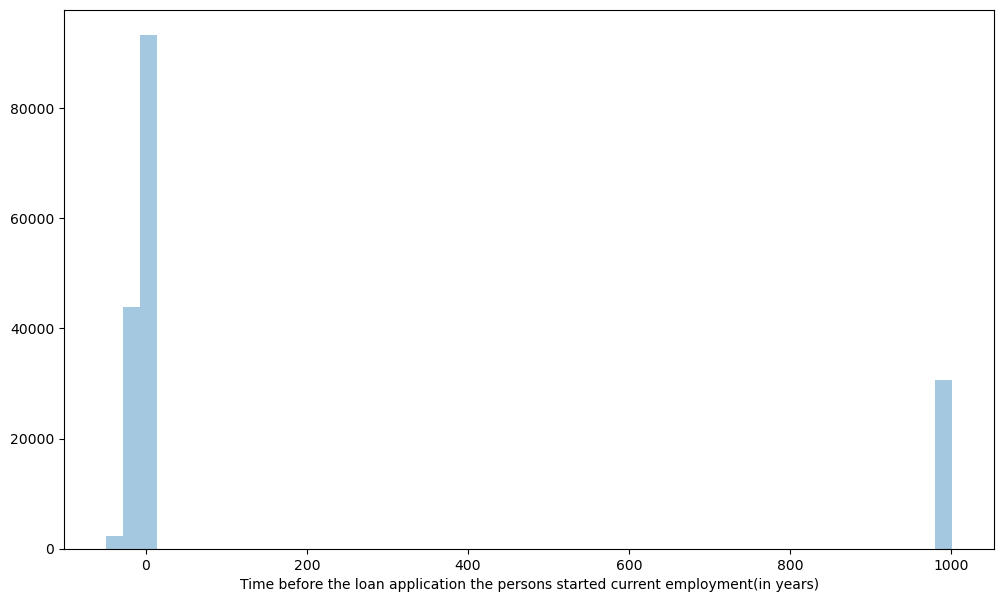

In [297]:
fig, ax = plt.subplots(figsize=(12,7))
sns.distplot(app_train['DAYS_EMPLOYED']/365,kde=False)
plt.xlabel("Time before the loan application the persons started current employment(in years)")


That's not right!

In [298]:
anomalies = app_train[(app_train['DAYS_EMPLOYED']/365>=900) & (app_train['DAYS_EMPLOYED']/365<=1100)]
len(anomalies)

30654

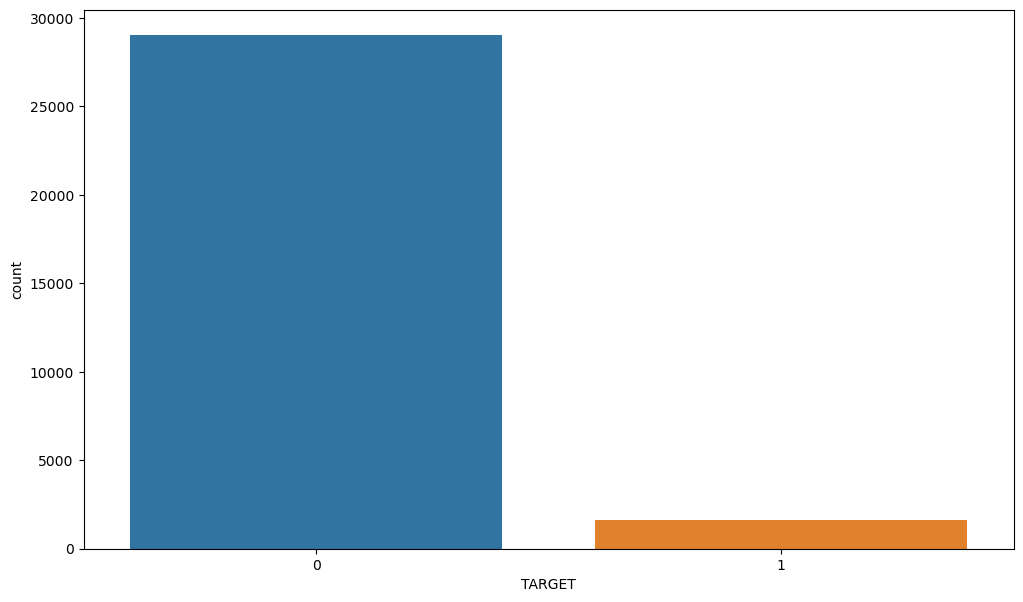

In [299]:
fig, ax = plt.subplots(figsize=(12,7))
sns.countplot(x='TARGET',data=anomalies)

plt.show()

Seems that people in the anomaly section are good at returning loans. Maybe the special 'marking' actually meant something? Same number 365243 repeats in previous_app dataframe. Let's get rid of it everywhere.

**The fix**

In [300]:
def replace_day_outliers(df):
    for col in df.columns:
        if "DAYS" in col:
            df[col] = df[col].replace({365243: np.nan})
            
    return df

app_train = replace_day_outliers(app_train)
app_test = replace_day_outliers(app_test)
bureau = replace_day_outliers(bureau)
bureau_balance = replace_day_outliers(bureau_balance)
credit = replace_day_outliers(credit)
cash = replace_day_outliers(cash)
previous_app = replace_day_outliers(previous_app)
installments = replace_day_outliers(installments)

In [301]:
app_train['AGE'] = app_train['DAYS_BIRTH'] / - 365
app_test['AGE'] = app_test['DAYS_BIRTH'] / - 365

In [302]:
app_train = app_train.drop('DAYS_BIRTH', axis=1)
app_test = app_test.drop('DAYS_BIRTH', axis=1)

In [303]:
print(app_train.shape)
print(app_test.shape)

(170000, 122)
(48744, 121)


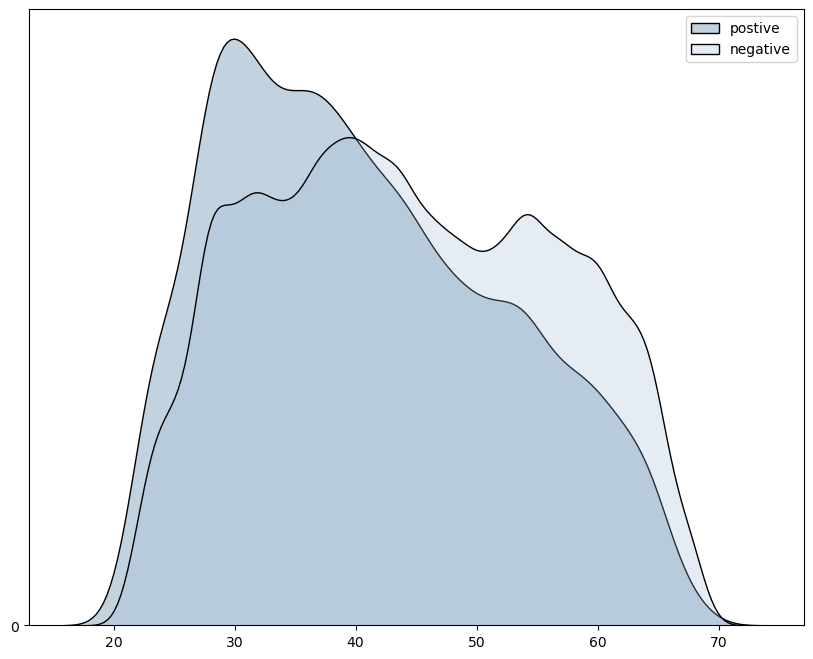

In [304]:
plot_kde('AGE')

A younger customer might fail their loans more often. The especially vulnerable group is less than 20 years old.

In [307]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AGE'],
      dtype='object', length=122)

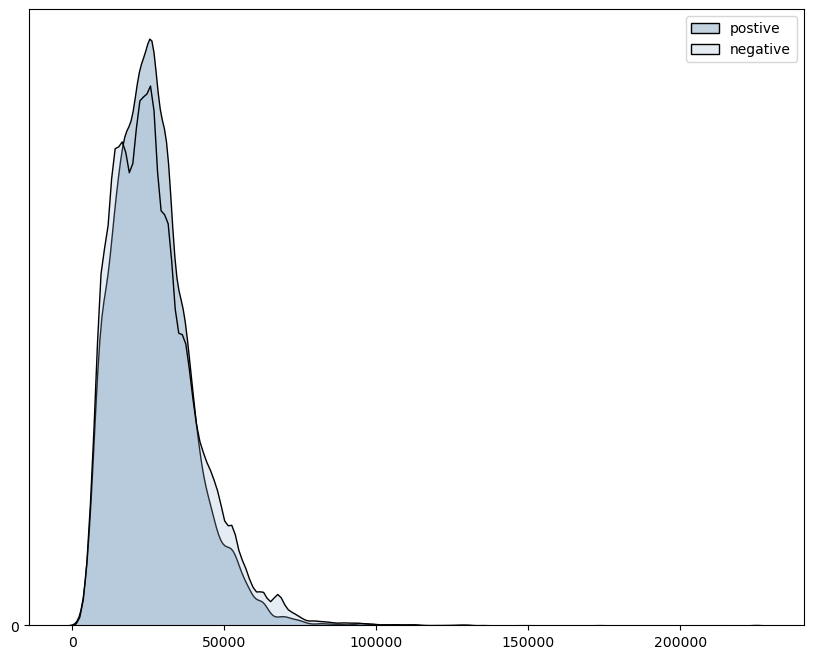

In [310]:
plot_kde('AMT_ANNUITY')

Only around 50 000 USD we can see the difference - those that are earning such a sum or bigger are more successful in paying us back.

**missing data**

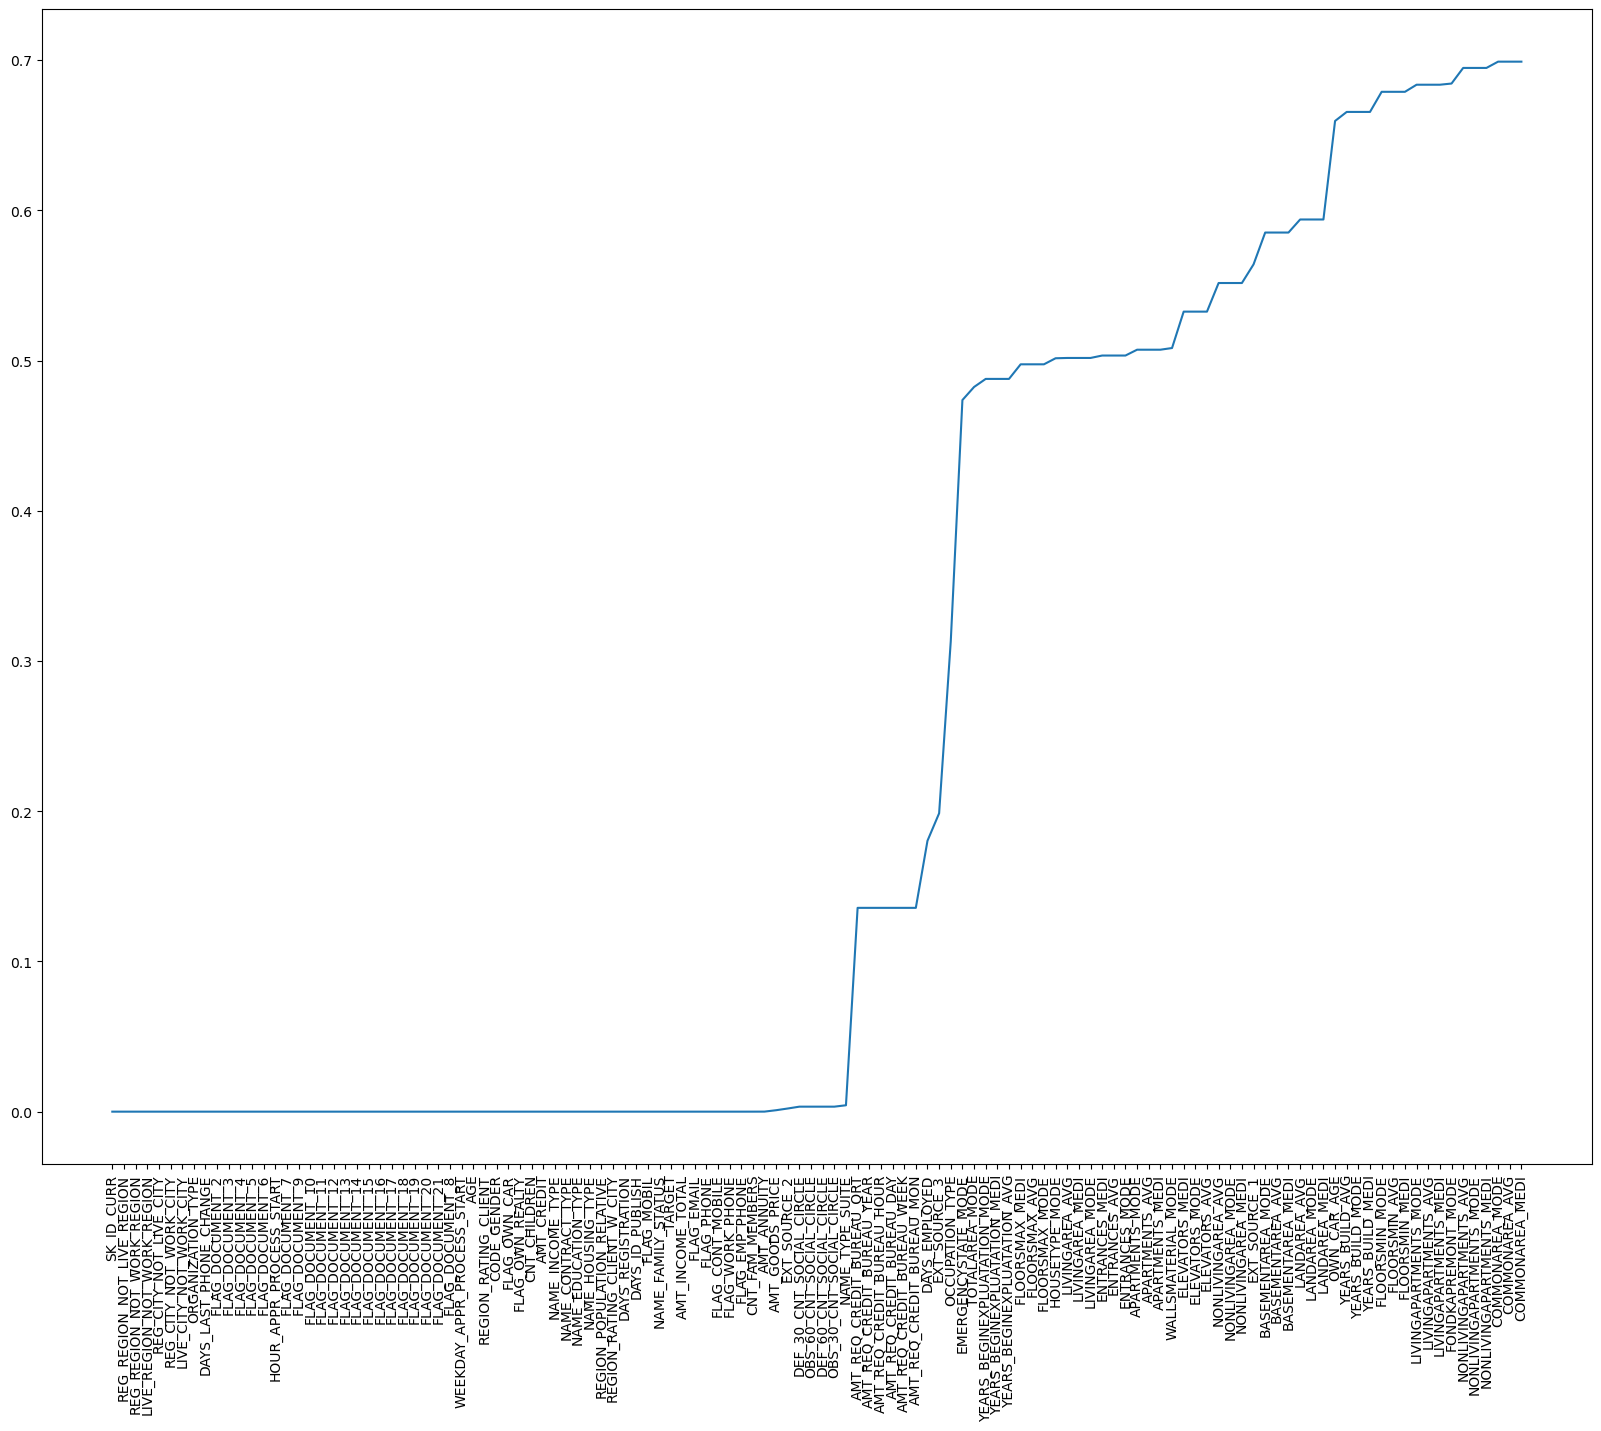

In [27]:
missing_value_train = app_train.isnull().mean()
plt.subplots(figsize=(20,15))
plt.xticks(rotation=90)
plt.plot(missing_value_train.sort_values())
plt.show()

**Weekday when approval process started**

In [28]:
app_train = app_train.drop('WEEKDAY_APPR_PROCESS_START', axis=1)
app_test = app_test.drop('WEEKDAY_APPR_PROCESS_START', axis=1)

# Filling missing values

1. Replacing by PCA components

  1.1 Housing

In [29]:
housing = app_train.columns[42:84]
housing

Index(['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
       'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE',
       'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
       'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI',
       'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI',
       'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI'],
      dtype='object')

In [30]:
from sklearn import preprocessing
h_temp = app_train[housing]

for i in housing:
    h_temp[i] = preprocessing.scale(h_temp[i])
    
h_temp = h_temp.fillna(0)
h_temp.head()

,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,...,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
2,-0.418945,-0.035522,0.0,-0.524902,-0.484863,-0.587891,-0.116394,-0.41626,-0.150024,-0.18457,...,-0.482178,-0.582031,-0.111328,-0.412354,-0.147583,-0.183105,-0.451172,-0.36499,-0.182007,-0.399902
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


,Explained Variance,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,...,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI
Dimension 1,0.4582,0.2419,0.1705,0.0,0.0838,0.1059,0.2199,0.1639,0.1791,0.1002,...,0.1059,0.2202,0.1635,0.1789,0.1000,0.1264,0.1662,0.2444,0.0330,0.0913
Dimension 2,0.1256,0.0222,0.1572,0.0,-0.1634,-0.0319,-0.0787,0.3175,-0.2987,-0.2279,...,-0.0310,-0.0777,0.3188,-0.2994,-0.2279,0.1726,-0.0169,0.0198,-0.0209,-0.0160
Dimension 3,0.0775,-0.0245,-0.0008,0.0,-0.0547,-0.0127,-0.0283,-0.0451,-0.0243,-0.0646,...,-0.0125,-0.0288,-0.0454,-0.0242,-0.0648,-0.0371,-0.0323,-0.0331,0.1957,0.5318
Dimension 4,0.0551,-0.0779,0.0364,0.0,0.3272,0.0698,-0.1538,0.0080,-0.0564,0.0577,...,0.0701,-0.1533,0.0078,-0.0559,0.0582,0.2420,0.0233,-0.0976,0.3306,-0.0801
Dimension 5,0.0541,0.0699,-0.0248,-0.0,-0.1816,0.1792,0.0625,0.0064,-0.0888,-0.0438,...,0.1791,0.0629,0.0071,-0.0899,-0.0444,-0.2868,0.1327,0.0330,0.3540,-0.1570
Dimension 6,0.0476,-0.0696,0.1406,-0.0,0.2464,0.2888,-0.0822,0.0741,-0.1360,-0.0045,...,0.2889,-0.0824,0.0742,-0.1367,-0.0049,-0.2552,0.1028,-0.0553,-0.2184,0.0888


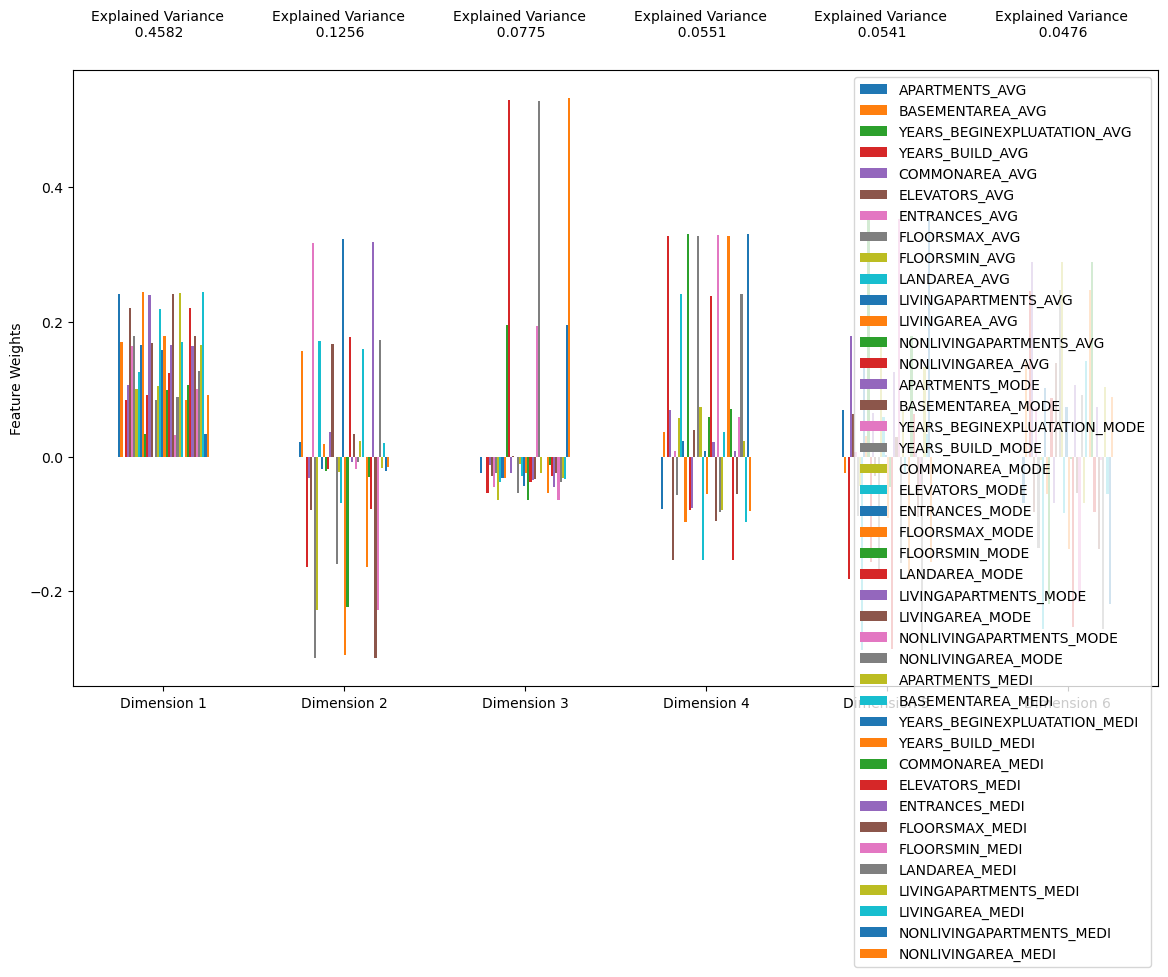

In [31]:
pca_test(h_temp, 6)

In [32]:
housing_PCA = pca_reduce_data(app_train[housing].fillna(0), 3)
housing_PCA_test = pca_reduce_data(app_test[housing].fillna(0), 3)

In [33]:
h = pd.DataFrame(housing_PCA, columns=["housing_1", "housing_2", "housing_3"])
h_test = pd.DataFrame(housing_PCA_test, columns=["housing_1", "housing_2", "housing_3"])

  1.2 Social circle

In [34]:
social_circle = app_train.columns[90:94]
social_circle

Index(['DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE'],
      dtype='object')

In [35]:
sc_temp = app_train[social_circle]
for i in social_circle:
    sc_temp[i] = preprocessing.scale(sc_temp[i])

    
sc_temp = sc_temp.fillna(0)
sc_temp.head()

,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
0,-0.319336,0.0,-0.275635,0.0
1,-0.319336,0.0,-0.275635,0.0
2,-0.319336,0.0,-0.275635,0.0
3,-0.319336,0.0,-0.275635,0.0
4,-0.319336,0.0,-0.275635,0.0


,Explained Variance,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE
Dimension 1,0.9318,0.7073,0.0,0.7070,0.0
Dimension 2,0.0682,0.7070,0.0,-0.7073,0.0
Dimension 3,0.0000,0.0000,0.0,0.0000,1.0
Dimension 4,0.0000,0.0000,-1.0,0.0000,0.0


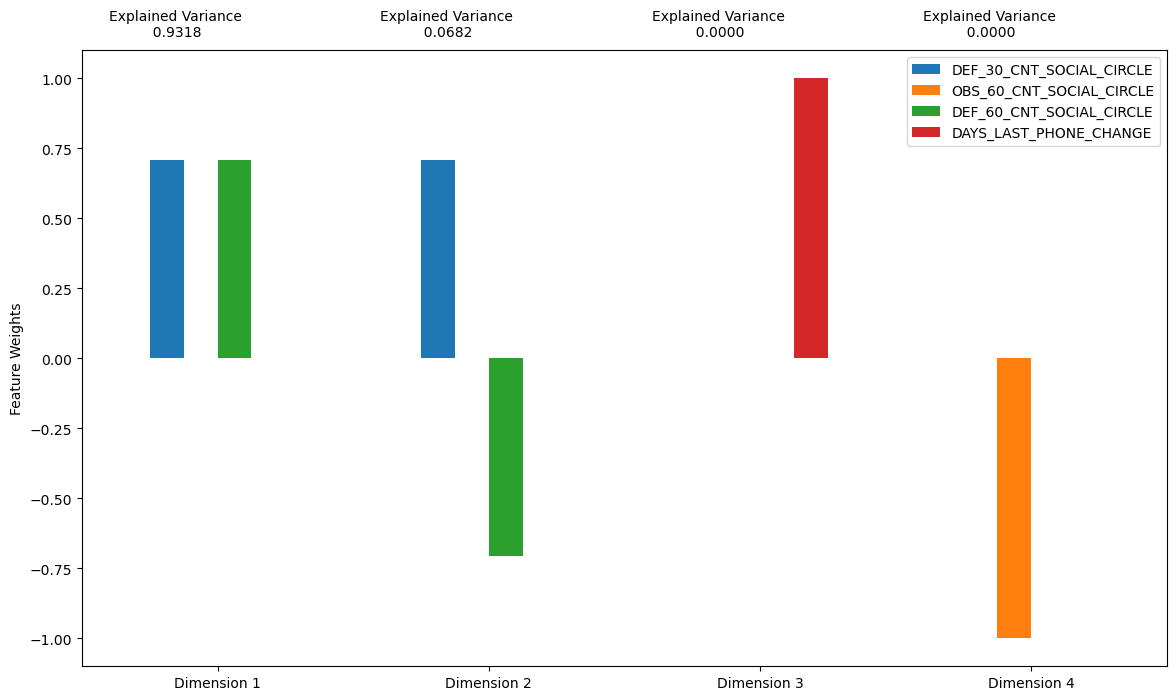

In [36]:
pca_test(sc_temp, 4)

In [37]:
social_circle_PCA = pca_reduce_data(app_train[social_circle].fillna(0), 2)
social_circle_PCA_test = pca_reduce_data(app_test[social_circle].fillna(0), 2)

In [38]:
s = pd.DataFrame(social_circle_PCA, columns=["sc_1", "sc_2"])
s_test = pd.DataFrame(social_circle_PCA_test, columns=["sc_1", "sc_2"])

1.3 Documents

In [39]:
document = app_train.columns[94:114]
document

Index(['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21'],
      dtype='object')

In [40]:
dc_temp = app_train[document]
for i in document:
    dc_temp[i] = preprocessing.scale(dc_temp[i])

dc_temp = dc_temp.fillna(0)
dc_temp.head()

,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,-0.006417,-1.558040,-0.006417,-0.123796,-0.312029,-0.013062,3.341083,-0.063559,-0.004851,-0.060843,-0.002425,-0.059812,-0.05371,-0.035668,-0.099815,-0.01698,-0.089936,-0.024622,-0.022101,-0.018633
1,-0.006417,0.641832,-0.006417,-0.123796,-0.312029,-0.013062,-0.299304,-0.063559,-0.004851,-0.060843,-0.002425,-0.059812,-0.05371,-0.035668,-0.099815,-0.01698,-0.089936,-0.024622,-0.022101,-0.018633
2,-0.006417,0.641832,-0.006417,-0.123796,-0.312029,-0.013062,-0.299304,-0.063559,-0.004851,-0.060843,-0.002425,-0.059812,-0.05371,-0.035668,-0.099815,-0.01698,-0.089936,-0.024622,-0.022101,-0.018633
3,-0.006417,0.641832,-0.006417,-0.123796,-0.312029,-0.013062,-0.299304,-0.063559,-0.004851,-0.060843,-0.002425,-0.059812,-0.05371,-0.035668,-0.099815,-0.01698,-0.089936,-0.024622,-0.022101,-0.018633
4,-0.006417,0.641832,-0.006417,-0.123796,-0.312029,-0.013062,-0.299304,-0.063559,-0.004851,-0.060843,-0.002425,-0.059812,-0.05371,-0.035668,-0.099815,-0.01698,-0.089936,-0.024622,-0.022101,-0.018633


,Explained Variance,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
Dimension 1,0.0830,0.0072,-0.7340,0.0077,0.1607,0.4654,0.0161,0.4451,0.0811,0.0068,...,-0.0027,0.0591,0.0014,0.0002,-0.0527,-0.0047,-0.0228,-0.0206,-0.0164,0.0228
Dimension 2,0.0584,-0.0046,-0.0055,-0.0074,0.1653,0.3711,-0.0101,-0.4753,0.0052,0.0230,...,0.1367,-0.3616,-0.1989,-0.1627,-0.3108,-0.1599,-0.1835,-0.1187,-0.4665,-0.0727
Dimension 3,0.0529,0.1292,-0.0383,0.2406,0.0762,0.3593,-0.1201,-0.3628,0.1036,-0.1363,...,0.0220,-0.2570,-0.0888,0.1278,0.2785,-0.0360,0.3625,0.2065,0.4776,0.1737
Dimension 4,0.0511,0.0509,0.0449,0.0536,-0.7333,0.3229,-0.0886,0.0687,-0.2209,-0.0499,...,0.2799,0.1764,0.0568,-0.0046,-0.1281,-0.1211,0.0789,-0.0515,-0.0409,-0.0515
Dimension 5,0.0505,0.0748,-0.0059,-0.0340,-0.1372,0.0074,0.0984,-0.0004,0.4725,-0.0237,...,0.0758,0.0611,-0.1996,-0.1460,0.6189,-0.1791,-0.4067,-0.2180,-0.0765,0.0651
Dimension 6,0.0504,0.0876,-0.0040,0.1789,0.1074,0.0115,-0.1149,0.0318,-0.0445,-0.0833,...,0.1357,-0.2441,0.4448,0.3895,0.1079,0.0306,-0.4287,0.1334,0.0438,-0.5123


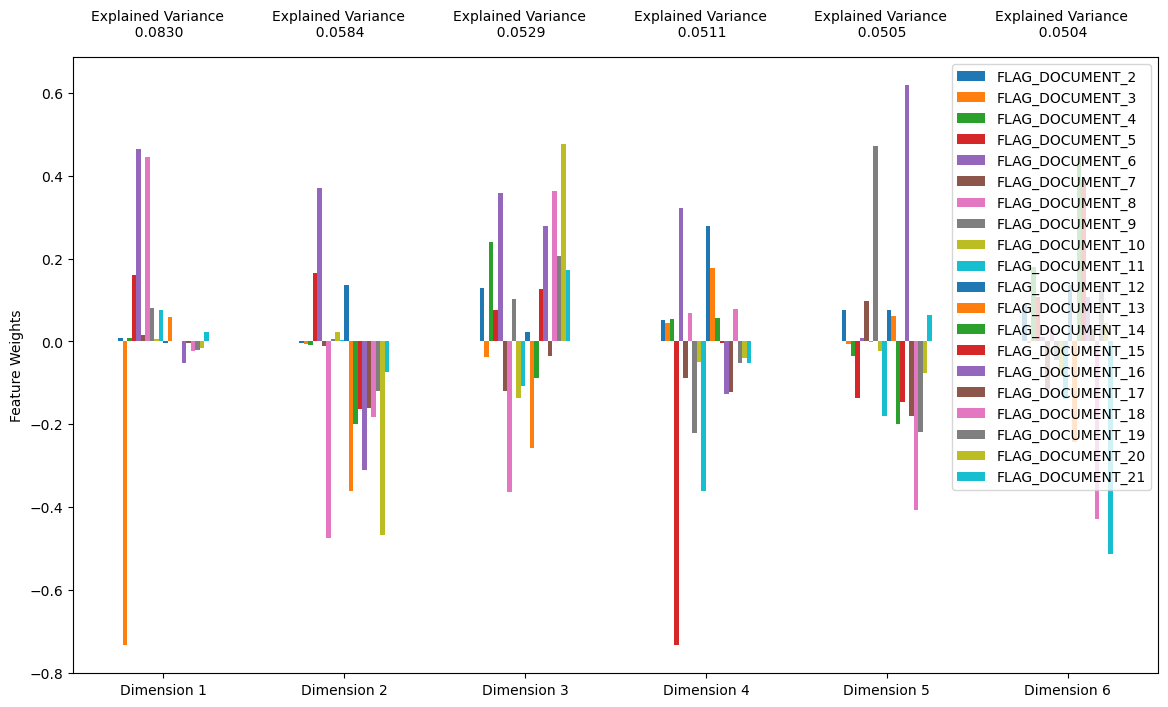

In [41]:
pca_test(dc_temp, 6)

In [42]:
document_PCA = pca_reduce_data(app_train[document].fillna(0), 6)
document_PCA_test = pca_reduce_data(app_test[document].fillna(0), 6)

In [43]:
d = pd.DataFrame(document_PCA, columns=["doc_1", "doc_2", "doc_3", "doc_4", "doc_5", "doc_6"])
d_test = pd.DataFrame(document_PCA_test, columns=["doc_1", "doc_2", "doc_3", "doc_4", "doc_5", "doc_6"])

1.4 Credit Bureau

In [44]:
credit_b = app_train.columns[114:120]
credit_b

Index(['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [45]:
cb_temp = app_train[credit_b]
for i in credit_b:
    cb_temp[i] = preprocessing.scale(cb_temp[i])

cb_temp = cb_temp.fillna(0)
cb_temp.head()

,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,-0.077087,-0.063293,-0.169922,-0.0,-0.0,0.0
1,-0.077087,-0.063293,-0.169922,-0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,-0.077087,-0.063293,-0.169922,-0.0,-0.0,0.0


,Explained Variance,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Dimension 1,0.4350,0.4997,0.7033,0.5056,0.0,0.0,0.0
Dimension 2,0.3321,0.7129,-0.0023,-0.7013,-0.0,-0.0,-0.0
Dimension 3,0.2329,-0.4921,0.7109,-0.5025,0.0,0.0,0.0


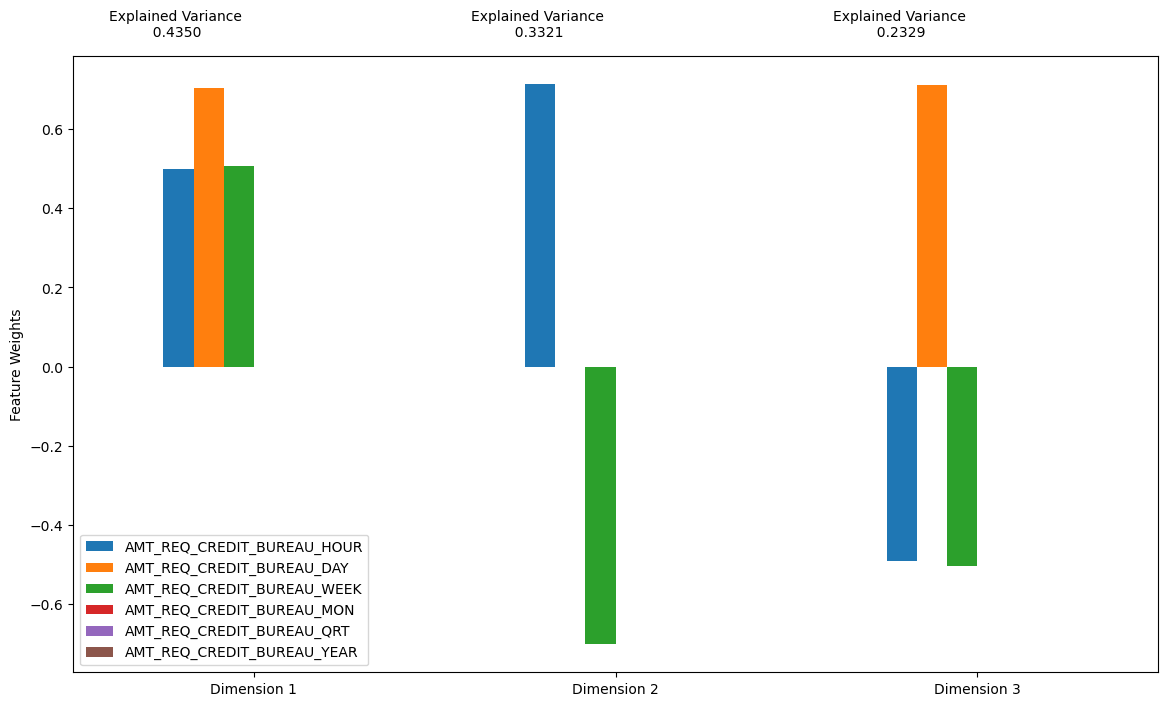

In [46]:
pca_test(cb_temp.fillna(0), 3)

In [47]:
credit_PCA = pca_reduce_data(app_train[credit_b].fillna(0), 3)
credit_PCA_test = pca_reduce_data(app_test[credit_b].fillna(0), 3)

c = pd.DataFrame(credit_PCA, columns=["c_1", "c_2", "c_3"])
c_test = pd.DataFrame(credit_PCA_test, columns=["c_1", "c_2", "c_3"])

**Droping no longer needed columns that now are represented by PCA**

In [48]:
pca_drop = housing.tolist() + social_circle.tolist() + document.tolist() + credit_b.tolist()
app_train = app_train.drop(pca_drop, axis=1)
app_test = app_test.drop(pca_drop, axis=1)

In [49]:
print(app_test.shape)
print(app_train.shape)

(48744, 48)
(170000, 49)


**Adding PCA features**

In [50]:
app_train = pd.concat([app_train, h, s, d, c], axis=1)
app_test = pd.concat([app_test, h_test, s_test, d_test, c_test], axis=1)

In [51]:
print(app_test.shape)
print(app_train.shape)

(48744, 62)
(170000, 63)


In [52]:
def print_missing(df):
  null_values = df.isnull().sum()
  null_values = null_values[null_values != 0].sort_values(ascending = False)
  null_values.columns = ["variable", "n_missing"]
  null_values.head()
  return null_values

In [53]:
null_values = print_missing(app_train)
null_values.head(20)

FONDKAPREMONT_MODE          116348
OWN_CAR_AGE                 112112
EXT_SOURCE_1                 95884
WALLSMATERIAL_MODE           86417
HOUSETYPE_MODE               85259
TOTALAREA_MODE               82008
EMERGENCYSTATE_MODE          80530
OCCUPATION_TYPE              53245
EXT_SOURCE_3                 33766
DAYS_EMPLOYED                30654
NAME_TYPE_SUITE                722
OBS_30_CNT_SOCIAL_CIRCLE       565
EXT_SOURCE_2                   356
AMT_GOODS_PRICE                162
AMT_ANNUITY                      4
CNT_FAM_MEMBERS                  1
dtype: int64

2. EXT SCORE variables

These variables are "normalized scores from external data sources". So although the clients with missing values probably weren't scored, each customer should have an "ideal score", at least in theory. So we can't give them a score 0 right away. Rather, let's see the distribution of all EXT SCORES and impute case by case.

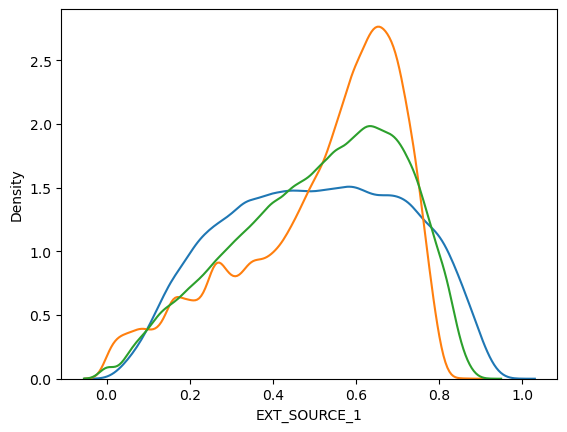

In [54]:
sns.kdeplot(app_train.EXT_SOURCE_1);
sns.kdeplot(app_train.EXT_SOURCE_2);
sns.kdeplot(app_train.EXT_SOURCE_3);
plt.show()

In [55]:
avg_ext = app_train.columns[39:42]
avg_ext

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], dtype='object')

In [56]:
e_PCA = pca_reduce_data(app_train[avg_ext].fillna(0), 1)
e_PCA_test = pca_reduce_data(app_test[avg_ext].fillna(0), 1)

e = pd.DataFrame(e_PCA, columns=["avg_ext"])
e_test = pd.DataFrame(e_PCA_test, columns=["avg_ext"])

In [57]:
app_train = pd.concat([app_train, e], axis=1)
app_test = pd.concat([app_test, e_test], axis=1)

In [58]:
dels = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']


app_train = app_train.drop(app_train[dels], axis =1)
app_test = app_test.drop(app_test[dels], axis =1)
gc.collect()

46583

In [59]:
print_missing(app_train)

FONDKAPREMONT_MODE          116348
OWN_CAR_AGE                 112112
WALLSMATERIAL_MODE           86417
HOUSETYPE_MODE               85259
TOTALAREA_MODE               82008
EMERGENCYSTATE_MODE          80530
OCCUPATION_TYPE              53245
DAYS_EMPLOYED                30654
NAME_TYPE_SUITE                722
OBS_30_CNT_SOCIAL_CIRCLE       565
AMT_GOODS_PRICE                162
AMT_ANNUITY                      4
CNT_FAM_MEMBERS                  1
dtype: int64

2. Credit Bureau

They are all about the timeframe. I'll do the same for all variables related to Credit Bureau. As they are "Number of inquiries to Credit Bureau about the client some predefined period before application", I assume that null quantities related to those variables are 0, meaning that no inquiries were made for that client.

In [60]:
app_train["AMT_GOODS_PRICE"] = app_train["AMT_GOODS_PRICE"].fillna(0)
app_train["AMT_ANNUITY"] = app_train["AMT_ANNUITY"].fillna(0)

app_test["AMT_GOODS_PRICE"] = app_test["AMT_GOODS_PRICE"].fillna(0)
app_test["AMT_ANNUITY"] = app_test["AMT_ANNUITY"].fillna(0)

3. Car ownership

65% of missing data doesn't seem to indicate a failure in collecting the data. There are no logical value to impute the car's age. To solve this, let's create a variable "own_car" and assign 1 to anyone who has a car and 0 otherwise.

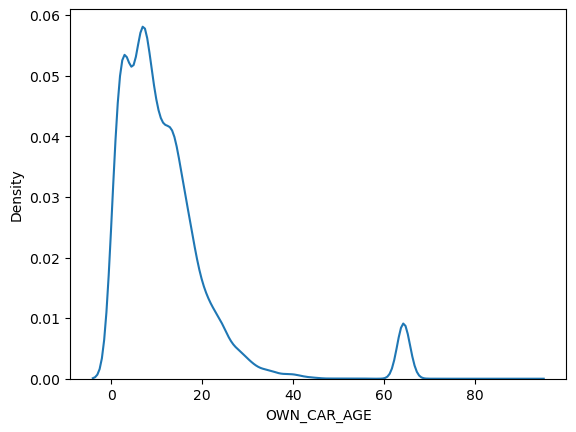

In [61]:
sns.kdeplot(app_train.OWN_CAR_AGE)
plt.show()

In [62]:
app_train["OWN_CAR"] = 0
app_train.loc[app_train.OWN_CAR_AGE >= 0, "OWN_CAR"] = 1
#app_train.loc[:,("OWN_CAR", "OWN_CAR_AGE")].head()
app_train = app_train.drop(columns=["OWN_CAR_AGE"])

In [63]:
app_test["OWN_CAR"] = 0
app_test.loc[app_test.OWN_CAR_AGE >= 0, "OWN_CAR"] = 1
#app_test.loc[:,("OWN_CAR", "OWN_CAR_AGE")].head()
app_test = app_test.drop(columns=["OWN_CAR_AGE"])

In [64]:
print_missing(app_train)

FONDKAPREMONT_MODE          116348
WALLSMATERIAL_MODE           86417
HOUSETYPE_MODE               85259
TOTALAREA_MODE               82008
EMERGENCYSTATE_MODE          80530
OCCUPATION_TYPE              53245
DAYS_EMPLOYED                30654
NAME_TYPE_SUITE                722
OBS_30_CNT_SOCIAL_CIRCLE       565
CNT_FAM_MEMBERS                  1
dtype: int64

4. Occupation type

This variable will be dealt with a bit differently than the others. We will use the education level of each person with a missing value in Occupation.

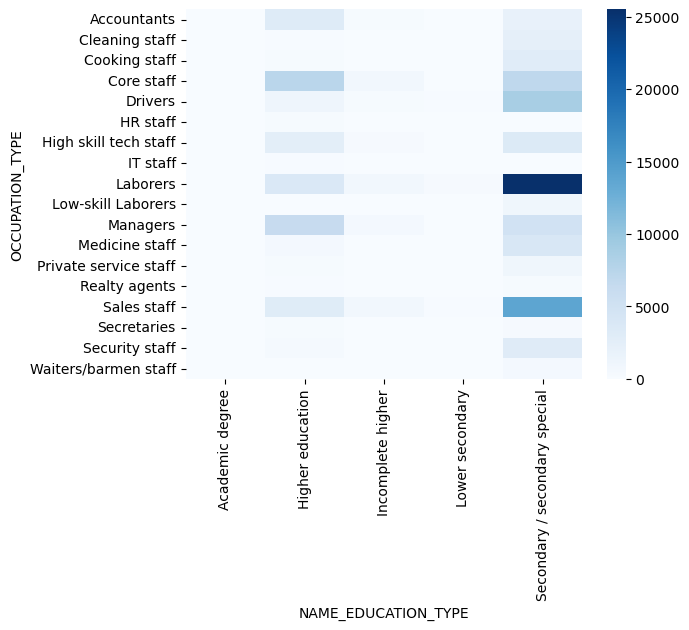

In [65]:
app_train.NAME_EDUCATION_TYPE.unique()
sns.heatmap(pd.crosstab(app_train.OCCUPATION_TYPE, app_train.NAME_EDUCATION_TYPE), cmap="Blues");

In [66]:
for education in app_train.NAME_EDUCATION_TYPE.unique():
    to_impute = app_train[app_train.NAME_EDUCATION_TYPE == education].OCCUPATION_TYPE.mode()[0]
    
    app_train.loc[app_train.NAME_EDUCATION_TYPE == education, "OCCUPATION_TYPE"] = app_train.loc[app_train.NAME_EDUCATION_TYPE == education, "OCCUPATION_TYPE"].fillna(to_impute)

5. Name type suite

By far, most people are unaccompanied, so we will use this value to impute NAME_TYPE_SUITE.

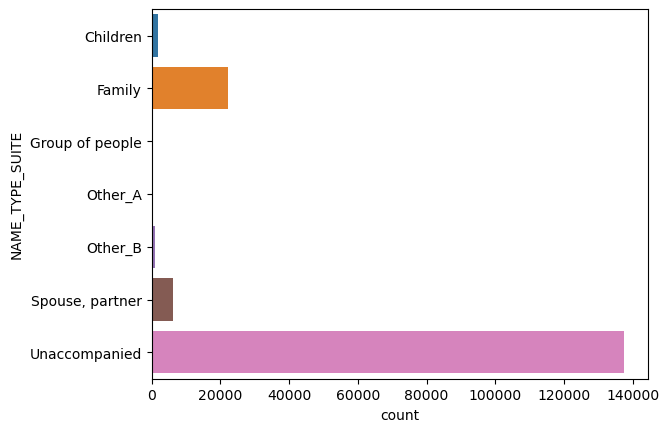

In [67]:
sns.countplot(y = app_train.NAME_TYPE_SUITE)
plt.show()

In [68]:
app_train.NAME_TYPE_SUITE = app_train.NAME_TYPE_SUITE.fillna(app_train.NAME_TYPE_SUITE.mode()[0])

6. Amount Annuity

The median value seems to be the best imputation value in this case, as the distribution is greatly skewed towards the left part.

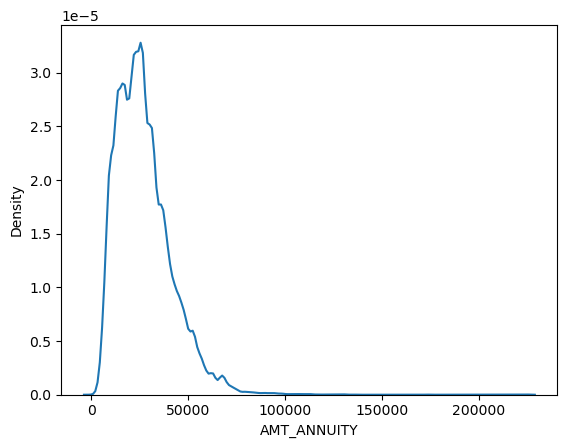

In [69]:
sns.kdeplot(app_train.AMT_ANNUITY)
plt.show()

In [70]:
app_train.AMT_ANNUITY = app_train.AMT_ANNUITY.fillna(app_train.AMT_ANNUITY.median())

8. Other missing values

Other missing values such as 'DAYS_EMPLOYED', 'AMT GOODS PRICE', 'COUNT FAM MEMBERS' will be filled at once with imputer later one using the mode.

In [71]:
print_missing(app_train)

FONDKAPREMONT_MODE          116348
WALLSMATERIAL_MODE           86417
HOUSETYPE_MODE               85259
TOTALAREA_MODE               82008
EMERGENCYSTATE_MODE          80530
DAYS_EMPLOYED                30654
OBS_30_CNT_SOCIAL_CIRCLE       565
CNT_FAM_MEMBERS                  1
dtype: int64

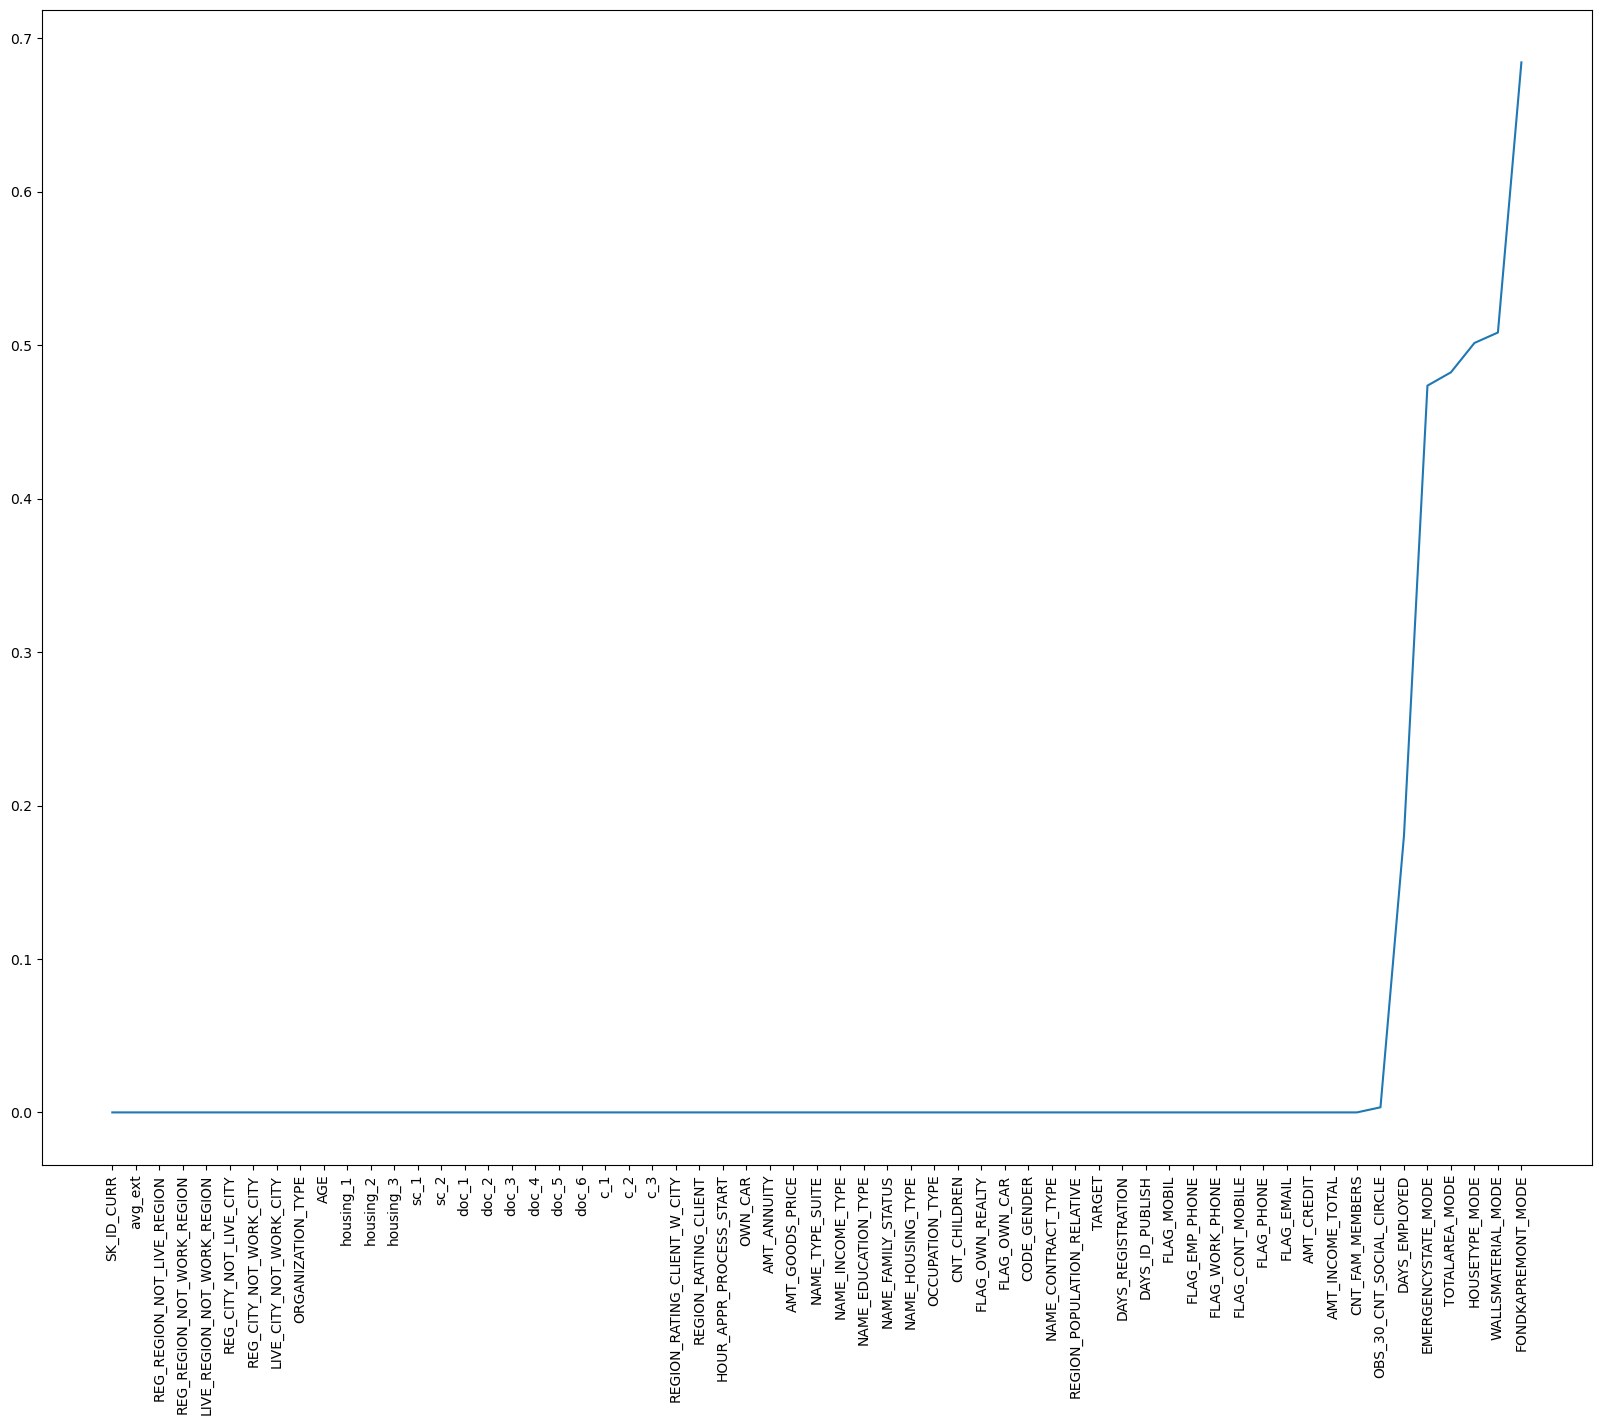

In [72]:
missing_value_train = app_train.isnull().mean()
plt.subplots(figsize=(20,15))
plt.xticks(rotation=90)
plt.plot(missing_value_train.sort_values())
plt.show()

**Droping columns not pasiing the treshold**

also dropping 'HOUR_APPR_PROCESS_START', as this feature is not important to determine the outcome of a loan.

In [73]:
to_drop = ['FONDKAPREMONT_MODE', 'WALLSMATERIAL_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE', 'EMERGENCYSTATE_MODE', 'HOUR_APPR_PROCESS_START']

app_train = app_train.drop(to_drop, axis=1)
app_test = app_test.drop(to_drop, axis=1)

In [74]:
gc.collect()

22323

# Feature engeneering

**Adding domain features**

Previous loans

In [75]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})

In [76]:
def count_previous_loans(df):

  df = df.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
  df['previous_loan_counts'] = df['previous_loan_counts'].fillna(0)
  return df

app_train = count_previous_loans(app_train)
app_test = count_previous_loans(app_test)

**credit anuity ratio**
credit_annuity_ratio: AMT_CREDIT / AMT_ANNUITY

In [77]:
app_train['credit_annuity_ratio'] = app_train['AMT_CREDIT']/app_train['AMT_ANNUITY']
app_test['credit_annuity_ratio'] = app_test['AMT_CREDIT']/app_test['AMT_ANNUITY']

**repaid_score**

The TARGET probability for loan to be repaid of the 500 closest neighbors of each row, where each neighborhood was defined by the credit/annuity ratio.

In [78]:
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)

app_train['credit_annuity_ratio'] = app_train['credit_annuity_ratio'].fillna(0)
app_test['credit_annuity_ratio'] = app_test['credit_annuity_ratio'].fillna(0)

In [79]:
from sklearn.neighbors import KNeighborsClassifier

def n_neighbors_value(df):
  predictors = ['credit_annuity_ratio']
  outcome = 'TARGET'

  X = df[predictors]
  y = df[outcome]

  knn = KNeighborsClassifier(n_neighbors=500, weights="distance")
  knn.fit(X, y)

  df['repaid_score'] = knn.predict_proba(X)[:, 1]

In [80]:
app_test['repaid_score'] = np.nan

In [81]:
n_neighbors_value(app_train)

**debt credit ratio**

debt_credit_ratio_None: grouped by SK_ID_CURR, the sum of all credit debt (AMT_CREDIT_SUM_DEBT) over the sum of all credit (AM_CREDIT_SUM).

In [82]:
app_train['amt_credit_sum'] = app_train.groupby('SK_ID_CURR')['AMT_CREDIT'].sum()
app_test['amt_credit_sum'] = app_test.groupby('SK_ID_CURR')['AMT_CREDIT'].sum()

In [83]:
app_train['debt_credit_ratio'] =  app_train['amt_credit_sum'] / app_train['AMT_CREDIT']
app_test['debt_credit_ratio'] =  app_test['amt_credit_sum'] / app_test['AMT_CREDIT']

**Other features**

In [84]:
app_train['credit_goods_price_ratio'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE']
app_test['credit_goods_price_ratio'] = app_test['AMT_CREDIT'] / app_test['AMT_GOODS_PRICE']

app_train['credit_downpayment'] = app_train['AMT_GOODS_PRICE'] - app_train['AMT_CREDIT'] 
app_test['credit_downpayment'] =  app_test['AMT_GOODS_PRICE'] - app_test['AMT_CREDIT']

In [85]:
def add_domain_features(df):
  df['DIR'] = df['AMT_CREDIT']/df['AMT_INCOME_TOTAL'] #LOAN_INCOME_RATIO
  df['AIR'] = df['AMT_ANNUITY']/df['AMT_INCOME_TOTAL'] #ANNUITY_INCOME_RATIO

  df['DAR'] = df['DAYS_EMPLOYED']/df['AGE']
  df['income_per_fam'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
  df['children_ratio'] = df['CNT_CHILDREN'] / df['CNT_FAM_MEMBERS']

add_domain_features(app_train)
add_domain_features(app_test)

# Previous applications

**Not nessasary columns**

In [86]:
previous_app = previous_app.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis = 1 )

**Checking missing values**

In [87]:
print_missing(previous_app)

RATE_INTEREST_PRIMARY        781010
RATE_INTEREST_PRIVILEGED     781010
DAYS_FIRST_DRAWING           754005
DAYS_TERMINATION             419099
AMT_DOWN_PAYMENT             415667
RATE_DOWN_PAYMENT            415667
DAYS_LAST_DUE                411777
NAME_TYPE_SUITE              384555
DAYS_LAST_DUE_1ST_VERSION    355445
DAYS_FIRST_DUE               330359
NFLAG_INSURED_ON_APPROVAL    311656
AMT_GOODS_PRICE              176992
AMT_ANNUITY                  170327
CNT_PAYMENT                  170324
PRODUCT_COMBINATION             162
AMT_CREDIT                        1
dtype: int64

**Filling in missing values**

1. Name type suite

Will be again filled by mode

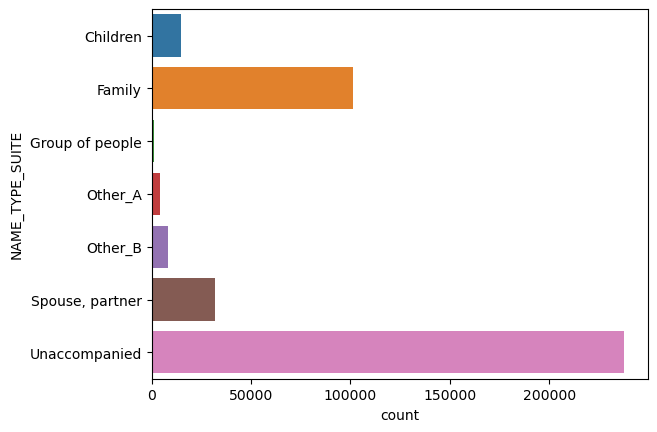

In [88]:
sns.countplot(y = previous_app.NAME_TYPE_SUITE)
plt.show()

In [89]:
previous_app.NAME_TYPE_SUITE = previous_app.NAME_TYPE_SUITE.fillna(previous_app.NAME_TYPE_SUITE.mode()[0])

**Features**

**prev_PRODUCT_COMBINATION**

most latest PRODUCT_COMBINATION value for the customer.

In [90]:
previous_app['prev_PRODUCT_COMBINATION'] = previous_app.groupby('SK_ID_PREV').aggregate({'PRODUCT_COMBINATION': 'last'})

In [91]:
previous_app = previous_app.drop('SK_ID_PREV', axis = 1)

In [92]:
app_train = app_train.merge(previous_app, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(previous_app, on = ['SK_ID_CURR'], how = 'left')

**Aggregations**

In [93]:
previous_app.columns = ['PA_'+column if column != ('SK_ID_CURR') 
                       else column for column in previous_app.columns]

In [94]:
def group_by_type(df):
  df_cat = pd.get_dummies(df.select_dtypes('category'))
  df_cat['SK_ID_CURR'] = df['SK_ID_CURR']
  df_cat = df_cat.groupby(by = ['SK_ID_CURR']).agg(['mean'])

  df_num = df.select_dtypes(exclude ='category').groupby(by = ['SK_ID_CURR']).agg(['max', 'mean', 'sum']).astype('float32')

  return df_cat, df_num

In [95]:
df_cat, df_num = group_by_type(previous_app)
prev_rev = df_num.merge(df_cat, on = ['SK_ID_CURR'], how = 'left')

In [96]:
app_train = app_train.merge(prev_rev, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(prev_rev, on = ['SK_ID_CURR'], how = 'left')

In [97]:
del previous_app
del prev_rev
del df_cat
del df_num
gc.collect()

3080

# Other datasets

**Bureau**

In [98]:
bb = pd.merge(bureau, bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

In [99]:
bb = bb.drop('SK_ID_BUREAU', axis=1)

**Features**

**Agg on SK ID CURR**

In [100]:
bb.columns = ['BB_'+column if column != ('SK_ID_CURR') 
                       else column for column in bb.columns]

In [101]:
df_cat, df_num = group_by_type(bb)

In [102]:
bureau_rev = df_cat.merge(df_num, on = ['SK_ID_CURR'], how = 'left')

In [103]:
app_train = app_train.merge(bureau_rev, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(bureau_rev, on = ['SK_ID_CURR'], how = 'left')

In [104]:
app_train = app_train.merge(bureau_rev, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(bureau_rev, on = ['SK_ID_CURR'], how = 'left')

In [105]:
import gc

del df_cat
del df_num
del bureau
del bureau_balance

gc.collect()

0

**Credit Card Balance**

**Features**

In [106]:
credit['DRAW_RATIO'] = credit['AMT_DRAWINGS_CURRENT'] / credit['CNT_DRAWINGS_CURRENT']
credit['RECEIVE_RATIO'] = credit['AMT_RECIVABLE'] / credit['AMT_RECEIVABLE_PRINCIPAL']
credit['RECEIVE_PER'] = credit['AMT_RECIVABLE'] / credit['AMT_TOTAL_RECEIVABLE']

In [107]:
credit.columns = ['CC_'+ column if column !='SK_ID_CURR' 
                  else column for column in credit.columns]

**Agg**

In [108]:
df_cat, df_num = group_by_type(credit)

In [109]:
app_train = app_train.merge(df_cat, on = ['SK_ID_CURR'], how = 'left')
app_train = app_train.merge(df_num, on = ['SK_ID_CURR'], how = 'left')

In [110]:
app_test = app_test.merge(df_cat, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(df_num, on = ['SK_ID_CURR'], how = 'left')

In [111]:
del credit
del df_cat
del df_num
gc.collect()

0

In [112]:
print(app_train.shape)
print(app_test.shape)

(792762, 510)
(48744, 509)


**Installments**

In [113]:
installments = installments.drop('SK_ID_PREV', axis=1)

**Features**

Let's aggregate over all installments that were past due. Where past due is defined as a 1 if the difference between DAYS_ENTRY_PAYMENT and DAYS_INSTALMENT was positive; and 0 if not.

In [114]:
installments["PAST_DUE"] = 0
installments['PAST_DUE'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
installments.loc[installments.PAST_DUE >=0, "PAST_DUE"] = 1
installments.loc[installments.PAST_DUE < 0, "PAST_DUE"] = 0

**Other features**

In [115]:
installments['PAY_PERCENT'] = installments['AMT_INSTALMENT'] / installments['AMT_PAYMENT']
installments['PAY_DIFF'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']

In [116]:
installments['DPD'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']

In [117]:
installments['DBD'] = installments['DAYS_INSTALMENT'] - installments['DAYS_ENTRY_PAYMENT']

In [118]:
installments.columns = ['IP_'+ column if column !='SK_ID_CURR' 
                   else column for column in installments.columns] 

In [119]:
inst_num = installments.groupby(by = ['SK_ID_CURR']).agg(['max', 'mean', 'sum']).astype('float32')

In [120]:
app_train = app_train.merge(inst_num, on = 'SK_ID_CURR', how='left')
app_test = app_test.merge(inst_num, on = 'SK_ID_CURR', how='left')

In [121]:
del installments
del inst_num
gc.collect()

0

In [122]:
print(app_train.shape)
print(app_test.shape)

(792762, 543)
(48744, 542)


**POS_CASH**

Outliers

In [123]:
cash = cash.drop('SK_ID_PREV', axis = 1)

In [124]:
cash.columns = ['PC_'+ column if column !='SK_ID_CURR' 
                   else column for column in cash.columns]

cash_num = cash.groupby(by = ['SK_ID_CURR']).agg(['max', 'mean', 'sum']).astype('float32')

app_train = app_train.merge(cash_num, on = ['SK_ID_CURR'], how = 'left')
app_test = app_test.merge(cash_num, on = ['SK_ID_CURR'], how = 'left')

In [125]:
del cash
del cash_num
gc.collect()

0

In [126]:
print(app_train.shape)
print(app_test.shape)

(792762, 558)
(48744, 557)


**Dropping almost empty columns**

In [127]:
perc = 75.0
min_count =  int(((100-perc)/100)*app_train.shape[0] + 1)
app_train = app_train.dropna(axis=1, thresh=min_count)

In [128]:
app_train.shape

(792762, 547)

**Allign columns of both dataframes**

In [129]:
train_list = app_train.columns.tolist()
test_list = app_test.columns.tolist()

to_drop = list(set(test_list)- set(train_list))

In [130]:
app_test = app_test.drop(to_drop, axis = 1)

In [131]:
gc.collect()

0

# Feature selection I: Correlations

Examine the correlations of the variables with the target. We can see in any of the variables we created have a greater correlation than those already present in the training data.

In [132]:
app_train = app_train.drop(['SK_ID_CURR'], axis=1)
app_test = app_test.drop(['SK_ID_CURR'], axis=1)

In [133]:
corrs = app_train.corr()
corrs = corrs.sort_values('TARGET', ascending = False)

In [134]:
pd.DataFrame(corrs['TARGET'].head(10))

,TARGET
TARGET,1.000000
repaid_score,0.474308
"(CC_CNT_DRAWINGS_ATM_CURRENT, mean)",0.101589
"(PA_NAME_CONTRACT_STATUS_Refused, mean)",0.100270
"(CC_CNT_DRAWINGS_CURRENT, max)",0.099102
"('BB_DAYS_CREDIT', 'mean')_x",0.091092
"(BB_DAYS_CREDIT, mean)",0.091092
"(PA_DAYS_FIRST_DRAWING, max)",0.081198
"(PA_DAYS_FIRST_DRAWING, mean)",0.080678
"(CC_AMT_BALANCE, mean)",0.080236


In [135]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

,TARGET
"(PA_NAME_PAYMENT_TYPE_Cash through the bank, mean)",-0.049908
"(PA_NAME_PORTFOLIO_POS, mean)",-0.050404
"(PA_NAME_YIELD_GROUP_low_normal, mean)",-0.051113
sc_1,-0.059002
AGE,-0.073357
"(BB_CREDIT_ACTIVE_Closed, mean)",-0.081984
"('BB_CREDIT_ACTIVE_Closed', 'mean')_x",-0.081984
"(PA_NAME_CONTRACT_STATUS_Approved, mean)",-0.091044
"(PA_CODE_REJECT_REASON_XAP, mean)",-0.097087
avg_ext,-0.104971


**Collinearity**

Calculate the correlation of each variable with every other variable. This will allow us to see if there are highly collinear variables that should perhaps be removed from the data. Look for any variables that have a greather than 0.7 correlation with other variables.

In [136]:
threshold = 0.7

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])
    
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_stay = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_stay.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  237


In [137]:
app_train = app_train.drop(columns = cols_to_remove)
app_test = app_test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', app_train.shape)
print('Testing Corrs Removed Shape: ', app_test.shape)

Training Corrs Removed Shape:  (792762, 309)
Testing Corrs Removed Shape:  (48744, 308)


Correlation is for continuous variables only. Using Pearson correlation for categorical or ordinal variables is not recommended (no matter if they are already encoded or not).

For categorical variables, you can find an association between the variables (instead of correlation) using the Chi-squared test of independence. This test is quite lenient, in the sense, even for a weak association it will show a low p-value. 

As we have only 4 categorical values - we will skip this step this time. 

# Preparing data



**Set values that stands for 'unknown' to nan values**

In [138]:
app_train.replace(['Unknown'], np.nan, inplace=True)
app_test.replace(['Unknown'], np.nan, inplace=True)

**Label encoding for less than or equal to 2 unique values**

In [139]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
transform_counter = 0

# iterate through all the categorical columns
for col in app_train.select_dtypes('category').columns:
    
    # select only those columns where number of unique values in the category is less than or equal to 2 
    if pd.Series.nunique(app_train[col]) <= 2:
        app_train[col] = le.fit_transform(app_train[col].astype(str))
        app_test[col] = le.fit_transform(app_test[col].astype(str))

        transform_counter+=1
        
print("Label encoded {} columns.".format(transform_counter))    


Label encoded 4 columns.


**One-hot encoding creating new column for each unique category in a categorical variable**

In [140]:
app_train = pd.get_dummies(app_train,drop_first=True)
app_test = pd.get_dummies(app_test,drop_first=True)

In [141]:
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (792762, 509)
Testing Features shape:  (48744, 506)


**Fix differences**

In [142]:
target = app_train['TARGET']
app_train =  app_train.drop(columns=["TARGET"])

In [143]:
train_list = app_train.columns.tolist()
test_list = app_test.columns.tolist()

to_drop = list(set(train_list)- set(test_list))
to_drop

['NAME_INCOME_TYPE_Maternity leave', 'CODE_GENDER_XNA']

In [144]:
app_train = app_train.drop(columns=to_drop)

**Imputer**

In [145]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean',verbose=0)

In [146]:
app_test.replace([np.inf, -np.inf], np.nan, inplace=True)
app_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [147]:
imputer.fit(app_train)
app_train[:] = imputer.transform(app_train)
app_test[:] = imputer.transform(app_test)

# Outliers

In [148]:
app_train = pd.concat([app_train, target], axis = 1)

In [149]:
app_train.shape

(792762, 507)

In [150]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(random_state=0)

df_without_outlier = pd.Series(iso_forest.fit_predict(app_train), index = app_train.index)
app_train = app_train.loc[df_without_outlier.index[df_without_outlier == 1],:]

In [151]:
app_train.shape

(792195, 507)

In [152]:
target = app_train["TARGET"]
app_train =  app_train.drop(columns=["TARGET"])

**Scaler**

In [153]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(app_train)

train_transformed = pd.DataFrame(scaler.transform(app_train), 
                                 index=app_train.index, 
                                 columns=app_train.columns)

In [154]:
test_transformed = pd.DataFrame(scaler.transform(app_test), 
                                 index=app_test.index, 
                                 columns=app_test.columns)

# Feature selection II: Quasi-Constant

In [155]:
columns = list(train_transformed)
X = pd.DataFrame(train_transformed, 
                 index = train_transformed.index, 
                 columns = train_transformed.columns)
y = target

**Removing Quasi-Constant Features**

Quasi-constant features, as the name suggests, are the features that are almost constant. In other words, these features have the same values for a very large subset of the outputs. Such features are not very useful for making predictions. There is no rule as to what should be the threshold for the variance of quasi-constant features. However, as a rule of thumb, remove those quasi-constant features that have more than 99% similar values for the output observations.

In [156]:
from sklearn.feature_selection import VarianceThreshold

def variance_threshold(df,th):
    var_thres=VarianceThreshold(threshold=th)
    var_thres.fit(df)
    new_cols = var_thres.get_support()
    return df.iloc[:,new_cols]

In [157]:
train_transformed = variance_threshold(X, 0.01)

**Fix differences in test and train set**

In [158]:
train_list = train_transformed.columns.tolist()
test_list = test_transformed.columns.tolist()

to_drop = list(set(test_list)- set(train_list))
len(to_drop)

303

In [159]:
test_transformed = test_transformed.drop(columns=to_drop)
test_transformed.shape

(48744, 203)

In [160]:
train_transformed.shape

(792195, 203)

some column names have special characters, that could not be read by some models, such as LightGBM

In [161]:
import re
train_transformed = train_transformed.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))
test_transformed = test_transformed.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', str(x)))

**Splitting to train and test sets**

In [162]:
from sklearn.model_selection import train_test_split



X_training_set, X_validation_set, y_training_set, y_validation_set = train_test_split(train_transformed, 
                                                                                      target, 
                                                                                      test_size=0.2, 
                                                                                      random_state=42,
                                                                                      shuffle=False)


**Resampling with SMOTE**

In [163]:
import collections
collections.Counter(y_training_set)

Counter({0: 579220, 1: 54536})

In [164]:
from imblearn.over_sampling import SMOTE
X_training_set, y_training_set = SMOTE().fit_resample(X_training_set, y_training_set)

In [165]:
collections.Counter(y_training_set)

Counter({0: 579220, 1: 579220})

# First run with the models
**1. Logistic regression**

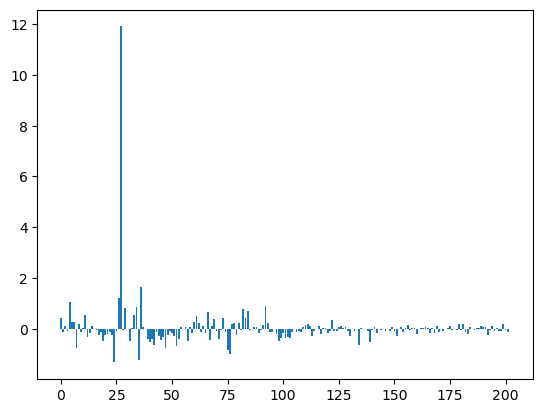

0    48335
1      409
Name: target, dtype: int64

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification

logistic_regressor = LogisticRegression(C=0.01, 
                                        penalty='l2',
                                        random_state = 50)
logistic_regressor.fit(X_training_set,y_training_set)

importance = logistic_regressor.coef_[0]
plt.bar([x for x in range(len(importance))], importance)
plt.show()

log_regression_pred = logistic_regressor.predict(X_validation_set)
logistic_test = logistic_regressor.predict(test_transformed)

pd.DataFrame({'target':logistic_test})['target'].value_counts()

**Minimization and Trade offs**

We know that there will be some error associated with every model that we use for predicting the true class of the target variable. This will result in False Positives and False Negatives(i.e Model classifying things incorrectly as compared to the actual class).

There’s no hard and fast rule that says what should be minimised in all the situations. It purely depends on the business needs and the context of the problem you are trying to solve. Based on that, we might want to minimise either False Positives or False negatives.


**Accuracy:**
Accuracy in classification problems is the number of correct predictions made by the model over all kinds predictions made.

**ROC AUC (Area under ROC):**

An evaluation metric that considers all possible classification thresholds.

The Area Under the ROC curve is the probability that a classifier will be more confident that a randomly chosen positive example is actually positive than that a randomly chosen negative example is positive.

**Precision-Recall curves** are very useful when there is a moderate to large class imbalance, therefore we will be looking at those too.


In [167]:
eval(log_regression_pred)

The accuracy in general is :  0.8160048977840052


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89    144997
           1       0.28      0.74      0.41     13442

    accuracy                           0.82    158439
   macro avg       0.63      0.78      0.65    158439
weighted avg       0.91      0.82      0.85    158439

ROC AUC score is:  0.7817590194471359


In [168]:
lr_probs = logistic_regressor.predict_proba(X_validation_set)
lr_probs = lr_probs[:, 1]

Logistic regression score: f1=0.406 auc=0.484


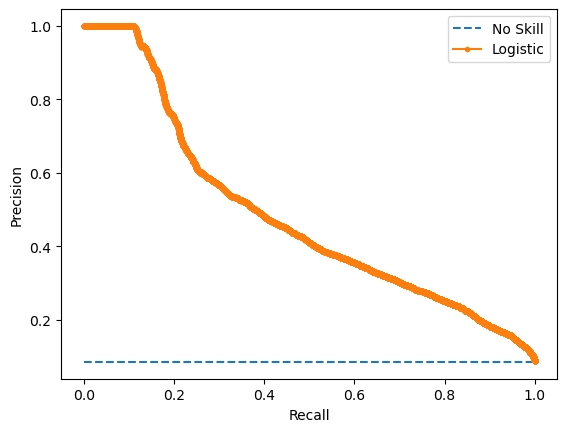

In [169]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


lr_precision, lr_recall, _ = precision_recall_curve(y_validation_set, lr_probs)

lr_f1, lr_auc = f1_score(y_validation_set, log_regression_pred), auc(lr_recall, lr_precision)

print('Logistic regression score: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

no_skill = len(y_validation_set[y_validation_set==1]) / len(y_validation_set)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

pyplot.legend()

pyplot.show()

The plot of the precision-recall curve highlights that the model is just barely above the no skill line for higher thresholds.

**1.1 Model explanation with SHAP**

In [170]:
import shap
shap.initjs()

In [171]:
features = list(X_training_set.columns)

In [172]:
masker = shap.maskers.Independent(data = X_training_set)
explainer = shap.LinearExplainer(logistic_regressor, masker=masker, feature_names=features)
shap_values = explainer.shap_values(X_training_set)

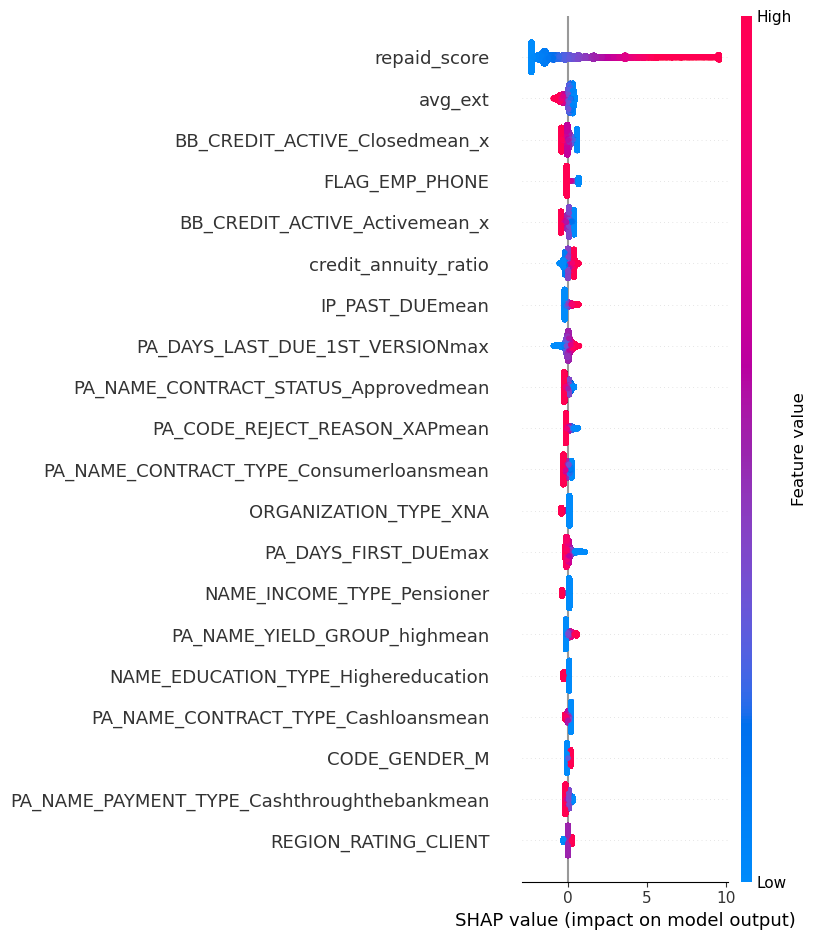

In [173]:
shap.summary_plot(shap_values, X_training_set)

Compared to our engineered 'repaid_score", other features are barely doing anything.  
Top feature table mostly consist of aggeregated features. 

In [174]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_training_set.iloc[0,:])

**2. Random Forest - Bagging ensemble of Decision trees**

In [175]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 500, 
                                       random_state = 50, 
                                       verbose = 1, 
                                       n_jobs = -1)

random_forest.fit(X_training_set,y_training_set)
random_forest_pred = random_forest.predict(X_validation_set)
random_forest_test = random_forest.predict(test_transformed)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.6s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed: 

In [176]:
eval(random_forest_pred)

The accuracy in general is :  0.8934795094642102


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94    144997
           1       0.37      0.37      0.37     13442

    accuracy                           0.89    158439
   macro avg       0.66      0.66      0.66    158439
weighted avg       0.89      0.89      0.89    158439

ROC AUC score is:  0.6567961743493254


**Feature importance**

We will be using the built in feature importance function, as SHAP is taking much longer.

In [177]:
feature_importance_df = pd.DataFrame({'Feature':features,
                                      'Importance':random_forest.feature_importances_})

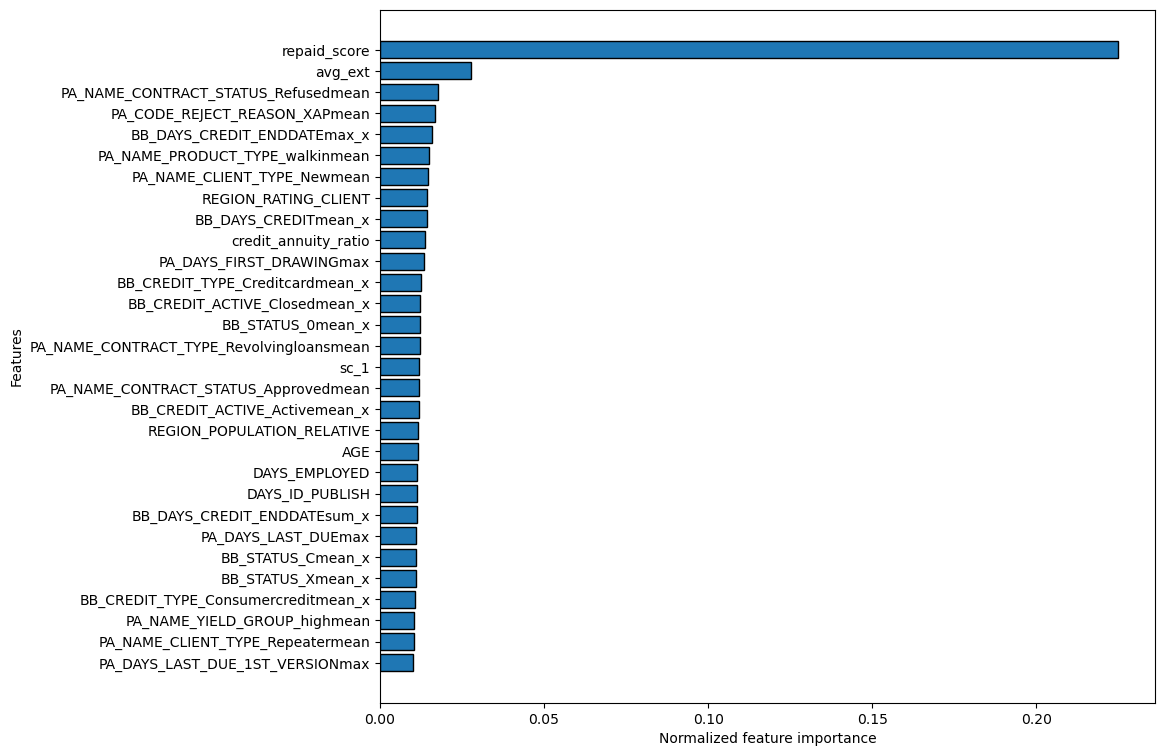

In [178]:
sorted_importance = plot_importance(feature_importance_df)

Looks similar to logistic regression results, yet we can see that features from BB table are dominating too.

**3.Extreme Gradient Boost Model**

In [179]:
from xgboost import XGBClassifier
xgb_classifier = XGBClassifier(n_estimators=250,
                               max_depth=5,
                               random_state = 50)
xgb_classifier.fit(X_training_set,y_training_set)
xgb_pred = xgb_classifier.predict(X_validation_set)
xgb_test = xgb_classifier.predict(test_transformed)
pd.DataFrame({'target':xgb_test})['target'].value_counts()

0    39711
1     9033
Name: target, dtype: int64

In [180]:
eval(xgb_pred)

The accuracy in general is :  0.9132473696501493


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95    144997
           1       0.48      0.32      0.39     13442

    accuracy                           0.91    158439
   macro avg       0.71      0.65      0.67    158439
weighted avg       0.90      0.91      0.91    158439

ROC AUC score is:  0.645626125278529


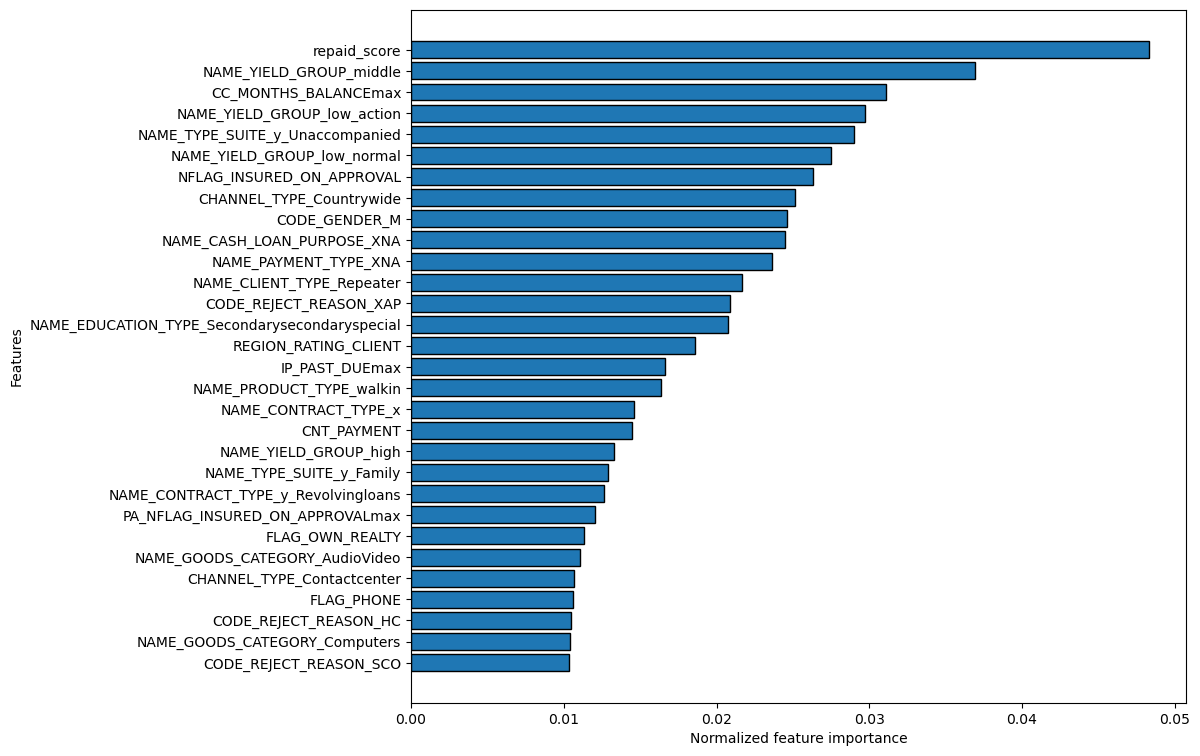

In [181]:
xgb_feature_importance_df = pd.DataFrame({'Feature':features,
                                          'Importance':xgb_classifier.feature_importances_})
sorted_importance = plot_importance(xgb_feature_importance_df)

Wow! Completely different picture. Seems like XGB makes use of more features and our main 'app_train' table is the most beneficial.

**4. Microsoft's LightGBM**

In [182]:
import lightgbm as lgb
lgb_classifier = lgb.LGBMClassifier(boosting_type='gbdt', 
                                    class_weight=None, 
                                    colsample_bytree=1.0,
                                    learning_rate=0.1, 
                                    max_depth=-1, 
                                    min_child_samples=20,
                                    min_child_weight=0.001, 
                                    min_split_gain=0.0, 
                                    n_estimators=100,
                                    n_jobs=-1, 
                                    num_leaves=40, 
                                    random_state=50,
                                    reg_alpha=0.0, 
                                    reg_lambda=0.0, 
                                    silent=True, subsample=1.0,
                                    subsample_for_bin=200000, 
                                    subsample_freq=0)

lgb_classifier.fit(X_training_set,y_training_set)
lgb_pred = lgb_classifier.predict(X_validation_set)
lgb_test = lgb_classifier.predict(test_transformed)
pd.DataFrame({'target':lgb_test})['target'].value_counts()

0    35698
1    13046
Name: target, dtype: int64

In [183]:
eval(lgb_pred)

The accuracy in general is :  0.9038178731246725


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    144997
           1       0.43      0.44      0.44     13442

    accuracy                           0.90    158439
   macro avg       0.69      0.69      0.69    158439
weighted avg       0.90      0.90      0.90    158439

ROC AUC score is:  0.692986958217464


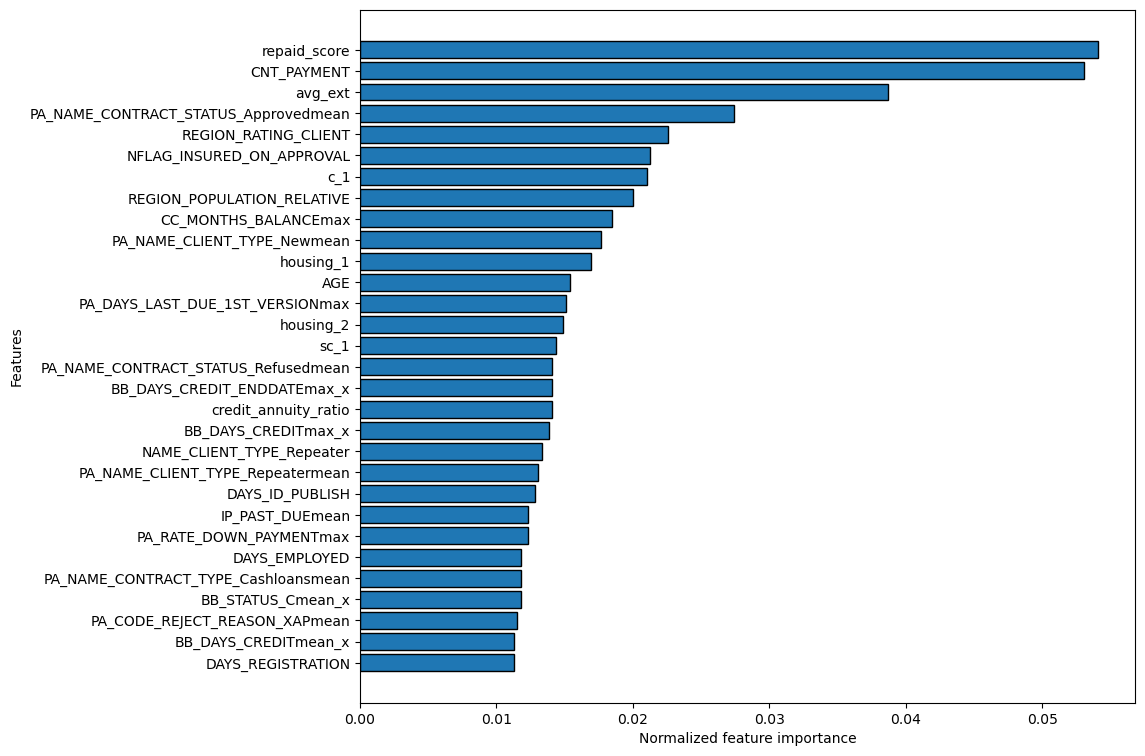

In [184]:
lgb_feature_importance_df = pd.DataFrame({'Feature':features,'Importance':lgb_classifier.feature_importances_/np.sum(lgb_classifier.feature_importances_)})
sorted_importance = plot_importance(lgb_feature_importance_df)

The CNT_PAYMENT is almost as important as repaid score.

**5. Naive Bayes Classifier**

In [185]:
from sklearn.naive_bayes import GaussianNB
bayes_class = GaussianNB()
bayes_class.fit(X_training_set,y_training_set)
bayes_preds = bayes_class.predict(X_validation_set)
bayes_test = bayes_class.predict(test_transformed)
pd.DataFrame({'target':bayes_test})['target'].value_counts()

1    40664
0     8080
Name: target, dtype: int64

In [186]:
eval(bayes_preds)

The accuracy in general is :  0.5762470098902417


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.95      0.57      0.71    144997
           1       0.13      0.69      0.22     13442

    accuracy                           0.58    158439
   macro avg       0.54      0.63      0.46    158439
weighted avg       0.88      0.58      0.67    158439

ROC AUC score is:  0.6300450760086681


The GaussianNB does not offer an intrinsic method to evaluate feature importances. Naïve Bayes methods work by determining the conditional and unconditional probabilities associated with the features and predicting the class with the highest probability. Thus, there are no coefficients computed or associated with the features we used to train the model.

That being said, there are methods that you can apply after the model has been trained. One of these methods is the Permutation Importance. 

In [187]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(bayes_class, X_validation_set, y_validation_set)

In [188]:
from __future__ import print_function

imps = imps.importances_mean
list(map(lambda X: print(X[0],X[1]), list(zip(features,imps))))

NAME_CONTRACT_TYPE_x -0.00033577591375857365
FLAG_OWN_CAR 5.8066511401899665e-05
FLAG_OWN_REALTY -0.00011991996919948899
REGION_POPULATION_RELATIVE 0.00031557886631450316
DAYS_EMPLOYED -0.0014440888922550466
DAYS_REGISTRATION 0.000825554314278687
DAYS_ID_PUBLISH 0.00016915027234460923
FLAG_EMP_PHONE 0.0024615151572529915
FLAG_WORK_PHONE 6.816503512394601e-05
FLAG_PHONE -0.00027897171782198527
FLAG_EMAIL -0.00019818352804548133
REGION_RATING_CLIENT 0.0002903325570093429
REG_REGION_NOT_LIVE_REGION -2.2721678374626463e-05
REG_REGION_NOT_WORK_REGION -0.00016031406408776317
REG_CITY_NOT_LIVE_CITY 0.0005579434356440371
REG_CITY_NOT_WORK_CITY -0.00018429805792763432
AGE 0.0012042489538560686
housing_1 2.5246309305182458e-05
housing_2 -0.0004077278952782759
sc_1 -0.00014642859396991615
doc_1 0.0005995998459975338
doc_2 0.0012383314714180305
doc_3 -0.0009644090154570462
c_1 -7.700124338072545e-05
avg_ext 0.0011259853950100762
OWN_CAR 5.8066511401899665e-05
credit_annuity_ratio 0.000108559130012

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

The numbers here represent the mean difference in the score (here: accuracy) the algorithm determined when the values of a particular feature are randomly shuffled before obtaining the score. So for example, a value of 0.20 means that shuffling this feature resulted in a drop of 0.20 in accuracy. Hence, this feature is very important. The negative numbers of course mean the opposite: the accuracy actually increased when shuffling the corresponding feature, so they are not that important.

# Feature selection III: leaving what is important

In [189]:
from sklearn.feature_selection import SelectFromModel

model_list = [logistic_regressor, xgb_classifier, lgb_classifier, random_forest,]
to_keep = []

for model in model_list:
    selector = SelectFromModel(threshold = 30, estimator=model, prefit=True)
    feature_idx = selector.get_support()
    to_append = X_training_set.columns[feature_idx]
    for column_name in to_append:
        to_keep.append(column_name)

to_keep = list(dict.fromkeys(to_keep))
len(to_keep)

45

In [190]:
to_keep

['REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'REGION_RATING_CLIENT',
 'AGE',
 'housing_1',
 'housing_2',
 'sc_1',
 'c_1',
 'avg_ext',
 'credit_annuity_ratio',
 'repaid_score',
 'CNT_PAYMENT',
 'NFLAG_INSURED_ON_APPROVAL',
 'PA_RATE_DOWN_PAYMENTmax',
 'PA_DAYS_DECISIONmax',
 'PA_DAYS_FIRST_DRAWINGmax',
 'PA_DAYS_LAST_DUE_1ST_VERSIONmax',
 'PA_DAYS_LAST_DUEmax',
 'PA_NAME_CONTRACT_TYPE_Cashloansmean',
 'PA_NAME_CONTRACT_STATUS_Approvedmean',
 'PA_NAME_CONTRACT_STATUS_Canceledmean',
 'PA_NAME_CONTRACT_STATUS_Refusedmean',
 'PA_CODE_REJECT_REASON_XAPmean',
 'PA_NAME_CLIENT_TYPE_Newmean',
 'PA_NAME_CLIENT_TYPE_Repeatermean',
 'PA_NAME_PRODUCT_TYPE_walkinmean',
 'PA_CHANNEL_TYPE_Contactcentermean',
 'PA_NAME_SELLER_INDUSTRY_Consumerelectronicsmean',
 'PA_NAME_YIELD_GROUP_highmean',
 'BB_CREDIT_ACTIVE_Closedmean_x',
 'BB_CREDIT_TYPE_Creditcardmean_x',
 'BB_STATUS_0mean_x',
 'BB_STATUS_Cmean_x',
 'BB_DAYS_CREDITmax_x',
 'BB_DAYS_CREDITmean_x',
 'B

In [191]:
X_training_set = X_training_set[to_keep]
X_validation_set = X_validation_set[to_keep]

In [192]:
X_training_set.shape

(1158440, 45)

In [193]:
gc.collect()

12626

# Model Ensembling

In [194]:
from scipy import stats
def stacked_model(X_training_set):
    """
    This method performs the stacked ensambling of all the models - XGBoost, LGBoost, Random forest, 
    Naive Bayes,Logistic Regression.
    """  
    stacked_predictions = np.array([])

    for element in X_training_set:
         stacked_predictions = np.append(stacked_predictions,stats.mode(element)[0][0])

    return stacked_predictions

In [195]:
combined_array = (pd.DataFrame({'LR':log_regression_pred,
                                'XGB':xgb_pred,
                                'LGB':lgb_pred,
                                'RF':random_forest_pred,
                                'Bayes':bayes_preds}).values)

In [196]:
combined_test = (pd.DataFrame({'LR':logistic_test,
                                'XGB':xgb_test,
                                'LGB':lgb_test,
                                'RF':random_forest_test,
                                'Bayes':bayes_test}).values)


In [197]:
stacked_model_pred = stacked_model(combined_array)
stacked_new = stacked_model(combined_test).astype(int)
pd.DataFrame({'target':stacked_new})['target'].value_counts()

0    40672
1     8072
Name: target, dtype: int64

In [198]:
eval(stacked_model_pred)

The accuracy in general is :  0.8944893618364166


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94    144997
           1       0.40      0.49      0.44     13442

    accuracy                           0.89    158439
   macro avg       0.68      0.71      0.69    158439
weighted avg       0.90      0.89      0.90    158439

ROC AUC score is:  0.7089156156109339


**With Sklearn StackingClassifier**

In [199]:
estimators = [('LR',logistic_regressor),
                ('XGB',xgb_classifier),
                ('LGB',lgb_classifier),
                ('RF',random_forest),
                ('Bayes',bayes_class)]

In [200]:
from sklearn.ensemble import StackingClassifier

clf =  StackingClassifier(estimators=estimators,
                         final_estimator = logistic_regressor)

In [201]:
stacking_model = clf.fit(X_training_set, y_training_set)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    2.0s fi

In [202]:
stacking_preds = clf.predict(X_validation_set)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.5s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.1s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.3s finished


In [203]:
eval(stacking_preds)

The accuracy in general is :  0.9175266190773737


The classification report is as follows:
               precision    recall  f1-score   support

           0       0.93      0.99      0.96    144997
           1       0.56      0.14      0.22     13442

    accuracy                           0.92    158439
   macro avg       0.74      0.56      0.59    158439
weighted avg       0.89      0.92      0.89    158439

ROC AUC score is:  0.5645715648907572


In [204]:
sm_probs = stacking_model.predict_proba(X_validation_set)
sm_probs = sm_probs[:, 1]

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    1.0s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.1s finished


Stacked model score: f1=0.223 auc=0.362


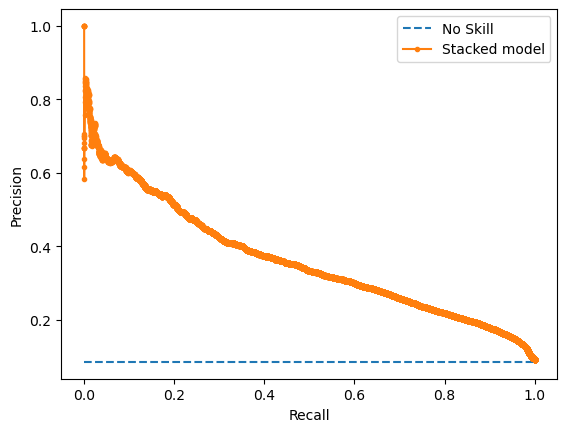

In [205]:
sm_precision, sm_recall, _ = precision_recall_curve(y_validation_set, sm_probs)

sm_f1, sm_auc = f1_score(y_validation_set, stacking_preds), auc(sm_recall, sm_precision)

print('Stacked model score: f1=%.3f auc=%.3f' % (sm_f1, sm_auc))

no_skill = len(y_validation_set[y_validation_set==1]) / len(y_validation_set)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(sm_recall, sm_precision, marker='.', label='Stacked model')

pyplot.xlabel('Recall')
pyplot.ylabel('Precision')

pyplot.legend()

pyplot.show()

# Saving the model

In [206]:
import pickle

with open('stacked_model.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

In [207]:
!zip -r ./stacked_model.zip ./staked_model.pkl

	zip warning: name not matched: ./staked_model.pkl

zip error: Nothing to do! (try: zip -r ./stacked_model.zip . -i ./staked_model.pkl)


In [208]:
import joblib
import gzip

joblib.dump(stacking_model, gzip.open('stacked_model_joblib.dat.gz', "wb"))

We successfully build very simple models that can take some details from our customer's bio and credit info, created a lot of features ourselves (the most successful being repaid_score, which corresponds to 500 nearest neighbors' score), and now can predict loan outcome.

Having an easy-to-interpret model that a loan officer can use to provide immediate estimates can not only speed up the process but also save lenders from potential losses. And it's good to have for our future customers as our model does not require all the lending history, but rather makes estimates of available, easy to aquire metrics.

**Refferences**

* https://www.kaggle.com/code/jundthird/kor-tuning-automated-feature-engineering

* https://github.com/rakshithvasudev/Home-Credit-Default-Risk/blob/master/Model%20Building/Home%20Credit%20Model.ipynb

* https://www.kaggle.com/code/megannichols/dsci-598-team-3-week-6-model/notebook

* https://www.kaggle.com/code/hrmello/application-train-imputation-guide-and-pca

* https://github.com/rezachu/Kaggle-Home-Credit-Default-Risk